In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)


from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *
from encoding_information.information_estimation import estimate_mutual_information



2024-10-14 07:05:33.582716: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 07:05:34.569141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-14 07:05:34.569273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-14 07:05:34.569287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Optimize the convolution matrix to map a delta towards a target signal

  0%|                                                   | 0/1 [00:00<?, ?it/s]

initial loss 0.08318112279708355


100%|██████████████████████████████████████████| 1/1 [04:56<00:00, 296.41s/it]


Array(0.99774883, dtype=float64)

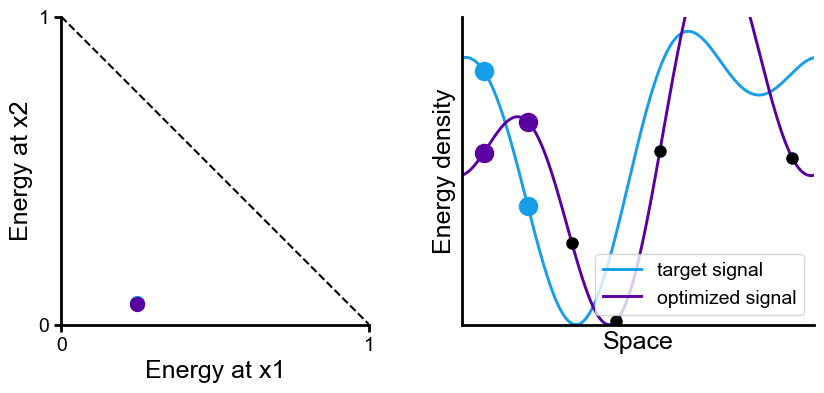

In [2]:
use_sampling_indices = False
sampling_indices = (0, 1)
unit_energy = True
num_nyquist_samples = 4

delta_function = generate_random_object('delta')

target_signal = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=unit_energy)
initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=True)

optimized_kernels, output_signals, optimized_params = optimize_towards_target_signals(
    [integrate_pixels(target_signal, num_nyquist_samples=num_nyquist_samples)], delta_function, initial_kernel, sampling_indices=sampling_indices if use_sampling_indices else None, verbose=True, return_params=True)
optimized_kernel = optimized_kernels[0]

initial_signal = make_convolutional_encoder(initial_kernel) @ delta_function
optimized_signal = make_convolutional_encoder(optimized_kernel) @ delta_function

# plot target and optimized signal in intensity and spatial coordinates
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_in_intensity_coordinates(ax[0], target_signal, label='target signal', sampling_indices=sampling_indices, num_nyquist_samples=num_nyquist_samples)
plot_in_intensity_coordinates(ax[0], optimized_signal, label='optimized signal', sampling_indices=sampling_indices, num_nyquist_samples=num_nyquist_samples)

plot_in_spatial_coordinates(ax[1], target_signal, label='target signal', sampling_indices=sampling_indices)
plot_in_spatial_coordinates(ax[1], optimized_signal, label='optimized signal', sampling_indices=sampling_indices, show_samples=True)
ax[1].legend()

optimized_signal.sum()

## Plot uniformly random signals

Generating signals: 1065it [00:23, 45.21it/s]


concatenating...


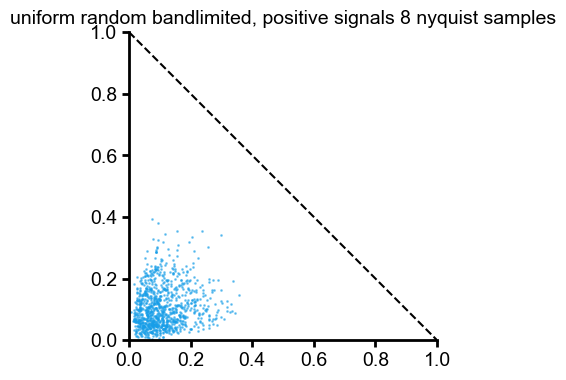

In [3]:
num_nyquist_samples = 8
num_signals = 1000
sampling_indices = (0, 1)

signals = generate_uniform_random_bandlimited_signals(num_nyquist_samples=num_nyquist_samples, num_signals=num_signals)
# signals = np.roll(signals, 64, axis=1)
integrated_signals = integrate_pixels(signals, num_nyquist_samples=num_nyquist_samples)

x1, x2 = integrated_signals[:, sampling_indices[0]], integrated_signals[:, sampling_indices[1]]
# now scatter only the positive targets
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(x1, x2, s=1, alpha=0.5)
# plot dashed line for the L1 ball
ax.plot(np.linspace(0, 1, 100), 1 - np.abs(np.linspace(0, 1, 100)), '--', color='k')
# square axes
ax.set_aspect('equal', 'box')
clear_spines(ax)
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.title.set_text('uniform random bandlimited, positive signals {} nyquist samples'.format(num_nyquist_samples))

## Compare entropy to uniform entropy

In [4]:
from encoding_information.models import PixelCNN, FullGaussianProcess, StationaryGaussianProcess 
from encoding_information.models import AnalyticGaussianNoiseModel
from encoding_information import estimate_information

confidence = 0.95


def compute_mutual_information_for_optimized_encoder(num_objects, num_nyquist_samples, noise_sigma, key,
                                                     upsampled_signal_length=UPSAMPLED_SIGNAL_LENGTH, test_fraction=0.1):
    
    objects_fn = lambda : np.array([generate_random_object('delta', object_size=upsampled_signal_length)
                                     for i in range(num_objects)])

    initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=True, upsampled_signal_length=upsampled_signal_length)
    initial_params = params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples)
    loss_fn = make_convolutional_forward_model_with_mi_loss(objects_fn(), noise_sigma, num_nyquist_samples=num_nyquist_samples, 
                                                            upsampled_signal_length=upsampled_signal_length)
    optimized_params = run_optimzation(loss_fn, lambda x : signal_prox_fn(x, num_nyquist_samples=num_nyquist_samples), 
                            initial_params,
                              learning_rate=1e-2, learning_rate_decay=0.999,
                              verbose=True,
                            loss_improvement_patience=2000,
                             max_epochs=3000, 
                             key=key)

    output_signals = conv_forward_model(optimized_params, objects_fn(), num_nyquist_samples=num_nyquist_samples, integrate_output_signals=True, 
                                        upsampled_signal_length=upsampled_signal_length)
    key, subkey = jax.random.split(key)
    noisy_signals = output_signals + noise_sigma * jax.random.normal(subkey, output_signals.shape)

    scale_factor = 1000 # becayse here its 0-1 range
    fake_images = noisy_signals.reshape(-1, int(np.sqrt(num_nyquist_samples)), int(np.sqrt(num_nyquist_samples))) * scale_factor

    train_fake_images = fake_images[:int(fake_images.shape[0] * (1 - test_fraction))]
    test_fake_images = fake_images[int(fake_images.shape[0] * (1 - test_fraction)):]

    pixel_cnn = PixelCNN()
    pixel_cnn.fit(train_fake_images, verbose=False)
    noise_model = AnalyticGaussianNoiseModel(noise_sigma*scale_factor)

    pixel_cnn_info, pixel_cnn_lower_bound, pixel_cnn_upper_bound = estimate_information(
            pixel_cnn, noise_model, train_fake_images, test_fake_images, confidence_interval=confidence)

    return pixel_cnn_info, pixel_cnn_lower_bound, pixel_cnn_upper_bound, subkey

def compute_uniform_samples_mi(num_signals, num_nyquist_samples, noise_sigma, key, upsampled_signal_length=UPSAMPLED_SIGNAL_LENGTH,
                                test_fraction=0.1):
                                
    uniformly_sampled_signals = generate_uniform_random_bandlimited_signals(num_nyquist_samples=num_nyquist_samples, 
                                                                            num_signals=num_signals, upsampled_signal_length=upsampled_signal_length)

    signals = integrate_pixels(uniformly_sampled_signals, num_nyquist_samples=num_nyquist_samples)

    noisy_signals = signals + noise_sigma * jax.random.normal(key, signals.shape)

    scale_factor = 1000 # becayse here its 0-1 range
    fake_images = noisy_signals.reshape(-1, int(np.sqrt(num_nyquist_samples)), int(np.sqrt(num_nyquist_samples))) * scale_factor

    train_fake_images = fake_images[:int(fake_images.shape[0] * (1 - test_fraction))]
    test_fake_images = fake_images[int(fake_images.shape[0] * (1 - test_fraction)):]

    pixel_cnn = PixelCNN()
    pixel_cnn.fit(train_fake_images, verbose=False)
    noise_model = AnalyticGaussianNoiseModel(noise_sigma*scale_factor)

    pixel_cnn_info, pixel_cnn_lower_bound, pixel_cnn_upper_bound = estimate_information(
            pixel_cnn, noise_model, train_fake_images, test_fake_images, confidence_interval=confidence)

    return pixel_cnn_info, pixel_cnn_lower_bound, pixel_cnn_upper_bound


def make_uniform_conv_mi_plot(conv_mi, conv_mi_lower, conv_mi_upper, uniform_mi, uniform_mi_lower, uniform_mi_upper, num_nyquist_samples_list):
        # plot toal mi
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        ax.plot(num_nyquist_samples_list, conv_mi, '-o', label='Best encoder')
        ax.fill_between(num_nyquist_samples_list, conv_mi_lower, conv_mi_upper, alpha=0.5, label=f'{confidence}% confidence interval')

        ax.plot(num_nyquist_samples_list, uniform_mi, '-o', label='Optimal signal distribution', color=get_color_cycle()[3])
        ax.fill_between(num_nyquist_samples_list, uniform_mi_lower, uniform_mi_upper, alpha=0.5, label=f'{confidence}% confidence interval', color=get_color_cycle()[3])

        ax.set(xlabel='Signal bandwidth (number of nyquist samples) ', ylabel='Mutual information (bits)')
        clear_spines(ax)
        ax.legend()



Nyquist Samples:   0%|                                  | 0/4 [00:00<?, ?it/s]

initial loss -5.307553272857522


2024-10-14 07:16:32.928232: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                            | 1/200 [00:32<1:47:24, 32.39s/it]

training:   1%|▎                              | 2/200 [00:35<49:07, 14.89s/it]

training:   2%|▍                              | 3/200 [00:37<30:32,  9.30s/it]

training:   2%|▌                              | 4/200 [00:40<21:48,  6.68s/it]

training:   2%|▊                              | 5/200 [00:43<17:05,  5.26s/it]

training:   3%|▉                              | 6/200 [00:45<14:12,  4.40s/it]

training:   4%|█                              | 7/200 [00:48<12:03,  3.75s/it]

training:   4%|█▏                             | 8/200 [00:50<10:53,  3.40s/it]

training:   4%|█▍                             | 9/200 [00:53<0

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<28:02,  8.46s/it]

training:   1%|▎                              | 2/200 [00:10<16:21,  4.96s/it]

training:   2%|▍                              | 3/200 [00:13<12:36,  3.84s/it]

training:   2%|▌                              | 4/200 [00:16<10:56,  3.35s/it]

training:   2%|▊                              | 5/200 [00:18<10:03,  3.10s/it]

training:   3%|▉                              | 6/200 [00:21<09:08,  2.83s/it]

training:   4%|█                              | 7/200 [00:24<09:16,  2.88s/it]

training:   4%|█▏                             | 8/200 [00:26<08:50,  2.76s/it]

training:   4%|█▍                             | 9/200 [00:29<08:33,  2.69s/it]

training:   5%|█▌                            | 10/200 [00:31<08:23,  2.65s/it]

training:   6%|█▋                            | 11/200 [00:34<08:13,  2.61s/it]

training:   6%|█▊                     

initial loss -4.894869165834319




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                            | 1/200 [00:33<1:51:44, 33.69s/it]

training:   1%|▎                              | 2/200 [00:36<50:27, 15.29s/it]

training:   2%|▍                              | 3/200 [00:38<30:35,  9.32s/it]

training:   2%|▌                              | 4/200 [00:40<21:23,  6.55s/it]

training:   2%|▊                              | 5/200 [00:42<16:12,  4.99s/it]

training:   3%|▉                              | 6/200 [00:45<13:17,  4.11s/it]

training:   4%|█                              | 7/200 [00:47<11:19,  3.52s/it]

training:   4%|█▏                             | 8/200 [00:49<09:55,  3.10s/it]

training:   4%|█▍                             | 9/200 [00:52<09:09,  2.88s/it]

training:   5%|█▌                            | 10/200 [00:54<08:36,  2.72s/it]

training:   6%|█▋                            | 11/200 [00:56<08:12,  2.60s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<29:29,  8.89s/it]

training:   1%|▎                              | 2/200 [00:11<17:07,  5.19s/it]

training:   2%|▍                              | 3/200 [00:14<13:04,  3.98s/it]

training:   2%|▌                              | 4/200 [00:16<10:50,  3.32s/it]

training:   2%|▊                              | 5/200 [00:18<09:47,  3.01s/it]

training:   3%|▉                              | 6/200 [00:21<09:00,  2.79s/it]

training:   4%|█                              | 7/200 [00:23<08:42,  2.71s/it]

training:   4%|█▏                             | 8/200 [00:26<08:25,  2.63s/it]

training:   4%|█▍                             | 9/200 [00:28<08:13,  2.59s/it]

training:   5%|█▌                            | 10/200 [00:31<07:59,  2.52s/it]

training:   6%|█▋                            | 11/200 [00:33<07:53,  2.51s/it]

training:   6%|█▊                     

initial loss -4.005161840614497




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                            | 1/200 [00:33<1:51:38, 33.66s/it]

training:   1%|▎                              | 2/200 [00:35<49:33, 15.02s/it]

training:   2%|▍                              | 3/200 [00:37<30:01,  9.15s/it]

training:   2%|▌                              | 4/200 [00:39<20:54,  6.40s/it]

training:   2%|▊                              | 5/200 [00:42<15:51,  4.88s/it]

training:   3%|▉                              | 6/200 [00:44<12:43,  3.93s/it]

training:   4%|█                              | 7/200 [00:46<10:47,  3.35s/it]

training:   4%|█▏                             | 8/200 [00:48<09:39,  3.02s/it]

training:   4%|█▍                             | 9/200 [00:50<08:40,  2.72s/it]

training:   5%|█▌                            | 10/200 [00:52<07:57,  2.51s/it]

training:   6%|█▋                            | 11/200 [00:55<07:38,  2.43s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<28:10,  8.49s/it]

training:   1%|▎                              | 2/200 [00:10<15:38,  4.74s/it]

training:   2%|▍                              | 3/200 [00:12<11:21,  3.46s/it]

training:   2%|▌                              | 4/200 [00:14<09:49,  3.01s/it]

training:   2%|▊                              | 5/200 [00:17<08:53,  2.73s/it]

training:   3%|▉                              | 6/200 [00:19<08:08,  2.52s/it]

training:   4%|█                              | 7/200 [00:21<07:56,  2.47s/it]

training:   4%|█▏                             | 8/200 [00:23<07:30,  2.35s/it]

training:   4%|█▍                             | 9/200 [00:26<07:38,  2.40s/it]

training:   5%|█▌                            | 10/200 [00:28<07:20,  2.32s/it]

training:   6%|█▋                            | 11/200 [00:30<07:07,  2.26s/it]

training:   6%|█▊                     

initial loss -3.6006077789567956




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                            | 1/200 [00:34<1:54:55, 34.65s/it]

training:   1%|▎                              | 2/200 [00:37<51:59, 15.76s/it]

training:   2%|▍                              | 3/200 [00:39<31:51,  9.70s/it]

training:   2%|▌                              | 4/200 [00:42<22:22,  6.85s/it]

training:   2%|▊                              | 5/200 [00:44<16:51,  5.19s/it]

training:   3%|▉                              | 6/200 [00:46<13:43,  4.24s/it]

training:   4%|█                              | 7/200 [00:49<11:45,  3.66s/it]

training:   4%|█▏                             | 8/200 [00:52<10:56,  3.42s/it]

training:   4%|█▍                             | 9/200 [00:54<10:09,  3.19s/it]

training:   5%|█▌                            | 10/200 [00:57<09:29,  3.00s/it]

training:   6%|█▋                            | 11/200 [00:59<08:53,  2.82s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:09<30:47,  9.29s/it]

training:   1%|▎                              | 2/200 [00:12<18:01,  5.46s/it]

training:   2%|▍                              | 3/200 [00:14<13:26,  4.10s/it]

training:   2%|▌                              | 4/200 [00:17<11:16,  3.45s/it]

training:   2%|▊                              | 5/200 [00:19<10:10,  3.13s/it]

training:   3%|▉                              | 6/200 [00:21<09:19,  2.89s/it]

training:   4%|█                              | 7/200 [00:24<08:51,  2.75s/it]

training:   4%|█▏                             | 8/200 [00:27<08:44,  2.73s/it]

training:   4%|█▍                             | 9/200 [00:29<08:23,  2.64s/it]

training:   5%|█▌                            | 10/200 [00:32<08:11,  2.59s/it]

training:   6%|█▋                            | 11/200 [00:34<07:50,  2.49s/it]

training:   6%|█▊                     

initial loss -5.219305273621923




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<27:32,  8.30s/it]

training:   1%|▎                              | 2/200 [00:10<15:27,  4.69s/it]

training:   2%|▍                              | 3/200 [00:12<11:16,  3.43s/it]

training:   2%|▌                              | 4/200 [00:14<09:36,  2.94s/it]

training:   2%|▊                              | 5/200 [00:16<08:36,  2.65s/it]

training:   3%|▉                              | 6/200 [00:18<07:58,  2.46s/it]

training:   4%|█                              | 7/200 [00:21<07:51,  2.44s/it]

training:   4%|█▏                             | 8/200 [00:23<07:29,  2.34s/it]

training:   4%|█▍                             | 9/200 [00:25<07:21,  2.31s/it]

training:   5%|█▌                            | 10/200 [00:27<07:19,  2.31s/it]

training:   6%|█▋                            | 11/200 [00:29<07:02,  2.24s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<29:36,  8.93s/it]

training:   1%|▎                              | 2/200 [00:11<16:21,  4.96s/it]

training:   2%|▍                              | 3/200 [00:13<12:24,  3.78s/it]

training:   2%|▌                              | 4/200 [00:15<10:19,  3.16s/it]

training:   2%|▊                              | 5/200 [00:17<09:00,  2.77s/it]

training:   3%|▉                              | 6/200 [00:19<08:19,  2.58s/it]

training:   4%|█                              | 7/200 [00:22<07:57,  2.48s/it]

training:   4%|█▏                             | 8/200 [00:24<07:30,  2.35s/it]

training:   4%|█▍                             | 9/200 [00:26<07:24,  2.33s/it]

training:   5%|█▌                            | 10/200 [00:28<07:21,  2.33s/it]

training:   6%|█▋                            | 11/200 [00:31<07:16,  2.31s/it]

training:   6%|█▊                     

initial loss -5.290316121665634




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:16,  7.62s/it]

training:   1%|▎                              | 2/200 [00:09<13:03,  3.96s/it]

training:   2%|▍                              | 3/200 [00:10<09:15,  2.82s/it]

training:   2%|▌                              | 4/200 [00:12<07:43,  2.37s/it]

training:   2%|▊                              | 5/200 [00:13<06:46,  2.08s/it]

training:   3%|▉                              | 6/200 [00:15<06:03,  1.87s/it]

training:   4%|█                              | 7/200 [00:16<05:38,  1.76s/it]

training:   4%|█▏                             | 8/200 [00:18<05:24,  1.69s/it]

training:   4%|█▍                             | 9/200 [00:19<05:12,  1.64s/it]

training:   5%|█▌                            | 10/200 [00:21<05:04,  1.60s/it]

training:   6%|█▋                            | 11/200 [00:22<04:59,  1.58s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<27:06,  8.17s/it]

training:   1%|▎                              | 2/200 [00:09<14:03,  4.26s/it]

training:   2%|▍                              | 3/200 [00:11<10:03,  3.06s/it]

training:   2%|▌                              | 4/200 [00:12<08:07,  2.49s/it]

training:   2%|▊                              | 5/200 [00:14<07:02,  2.17s/it]

training:   3%|▉                              | 6/200 [00:16<06:19,  1.95s/it]

training:   4%|█                              | 7/200 [00:17<05:50,  1.81s/it]

training:   4%|█▏                             | 8/200 [00:19<05:39,  1.77s/it]

training:   4%|█▍                             | 9/200 [00:20<05:27,  1.71s/it]

training:   5%|█▌                            | 10/200 [00:22<05:14,  1.66s/it]

training:   6%|█▋                            | 11/200 [00:24<05:10,  1.64s/it]

training:   6%|█▊                     

initial loss -3.9999058232425075




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<26:28,  7.98s/it]

training:   1%|▎                              | 2/200 [00:09<13:46,  4.17s/it]

training:   2%|▍                              | 3/200 [00:11<09:56,  3.03s/it]

training:   2%|▌                              | 4/200 [00:12<07:50,  2.40s/it]

training:   2%|▊                              | 5/200 [00:14<06:39,  2.05s/it]

training:   3%|▉                              | 6/200 [00:15<06:12,  1.92s/it]

training:   4%|█                              | 7/200 [00:17<05:44,  1.78s/it]

training:   4%|█▏                             | 8/200 [00:18<05:28,  1.71s/it]

training:   4%|█▍                             | 9/200 [00:20<05:22,  1.69s/it]

training:   5%|█▌                            | 10/200 [00:21<05:08,  1.62s/it]

training:   6%|█▋                            | 11/200 [00:23<05:00,  1.59s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<28:52,  8.71s/it]

training:   1%|▎                              | 2/200 [00:10<15:26,  4.68s/it]

training:   2%|▍                              | 3/200 [00:12<11:25,  3.48s/it]

training:   2%|▌                              | 4/200 [00:14<09:26,  2.89s/it]

training:   2%|▊                              | 5/200 [00:16<08:10,  2.51s/it]

training:   3%|▉                              | 6/200 [00:18<07:15,  2.24s/it]

training:   4%|█                              | 7/200 [00:19<06:38,  2.07s/it]

training:   4%|█▏                             | 8/200 [00:21<06:18,  1.97s/it]

training:   4%|█▍                             | 9/200 [00:23<06:02,  1.90s/it]

training:   5%|█▌                            | 10/200 [00:25<05:48,  1.83s/it]

training:   6%|█▋                            | 11/200 [00:26<05:40,  1.80s/it]

training:   6%|█▊                     

initial loss -2.9814433827421984




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<28:13,  8.51s/it]

training:   1%|▎                              | 2/200 [00:10<15:13,  4.61s/it]

training:   2%|▍                              | 3/200 [00:12<11:00,  3.35s/it]

training:   2%|▌                              | 4/200 [00:14<09:26,  2.89s/it]

training:   2%|▊                              | 5/200 [00:16<08:11,  2.52s/it]

training:   3%|▉                              | 6/200 [00:18<07:17,  2.25s/it]

training:   4%|█                              | 7/200 [00:20<07:11,  2.24s/it]

training:   4%|█▏                             | 8/200 [00:22<06:42,  2.09s/it]

training:   4%|█▍                             | 9/200 [00:23<06:22,  2.00s/it]

training:   5%|█▌                            | 10/200 [00:25<06:09,  1.94s/it]

training:   6%|█▋                            | 11/200 [00:27<05:52,  1.86s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                                                                      | 0/200 [00:00<?, ?it/s]

training:   0%|▍                                                                             | 1/200 [00:08<28:23,  8.56s/it]

training:   1%|▊                                                                             | 2/200 [00:10<15:24,  4.67s/it]

training:   2%|█▏                                                                            | 3/200 [00:12<11:05,  3.38s/it]

training:   2%|█▌                                                                            | 4/200 [00:14<09:03,  2.77s/it]

training:   2%|█▉                                                                            | 5/200 [00:16<08:03,  2.48s/it]

training:   3%|██▎                                                                           | 6/200 [00:18<07:25,  2.30s/it]

training:   4%|██▋                                                                           | 7/200 [00:20<0

initial loss -5.156090146542046




training:   0%|                                                                                      | 0/200 [00:00<?, ?it/s]

training:   0%|▍                                                                             | 1/200 [00:09<29:55,  9.02s/it]

training:   1%|▊                                                                             | 2/200 [00:11<17:16,  5.23s/it]

training:   2%|█▏                                                                            | 3/200 [00:13<12:32,  3.82s/it]

training:   2%|█▌                                                                            | 4/200 [00:16<10:29,  3.21s/it]

training:   2%|█▉                                                                            | 5/200 [00:18<09:19,  2.87s/it]

training:   3%|██▎                                                                           | 6/200 [00:20<08:47,  2.72s/it]

training:   4%|██▋                                                                           | 7/200 [00:22<0

concatenating...




training:   0%|                                                                                      | 0/200 [00:00<?, ?it/s]

training:   0%|▍                                                                             | 1/200 [00:09<32:23,  9.77s/it]

training:   1%|▊                                                                             | 2/200 [00:12<17:53,  5.42s/it]

training:   2%|█▏                                                                            | 3/200 [00:14<13:29,  4.11s/it]

training:   2%|█▌                                                                            | 4/200 [00:17<11:10,  3.42s/it]

training:   2%|█▉                                                                            | 5/200 [00:19<09:39,  2.97s/it]

training:   3%|██▎                                                                           | 6/200 [00:21<08:55,  2.76s/it]

training:   4%|██▋                                                                           | 7/200 [00:24<0

initial loss -5.159907630690807




training:   0%|                                                                                      | 0/200 [00:00<?, ?it/s]

training:   0%|▍                                                                             | 1/200 [00:09<31:55,  9.63s/it]

training:   1%|▊                                                                             | 2/200 [00:12<18:45,  5.68s/it]

training:   2%|█▏                                                                            | 3/200 [00:15<14:02,  4.28s/it]

training:   2%|█▌                                                                            | 4/200 [00:17<11:37,  3.56s/it]

training:   2%|█▉                                                                            | 5/200 [00:20<10:18,  3.17s/it]

training:   3%|██▎                                                                           | 6/200 [00:22<09:36,  2.97s/it]

training:   4%|██▋                                                                           | 7/200 [00:25<0

concatenating...




training:   0%|                                                                                      | 0/200 [00:00<?, ?it/s]

training:   0%|▍                                                                             | 1/200 [00:09<31:38,  9.54s/it]

training:   1%|▊                                                                             | 2/200 [00:12<18:06,  5.49s/it]

training:   2%|█▏                                                                            | 3/200 [00:14<13:40,  4.16s/it]

training:   2%|█▌                                                                            | 4/200 [00:17<12:00,  3.68s/it]

training:   2%|█▉                                                                            | 5/200 [00:20<10:53,  3.35s/it]

training:   3%|██▎                                                                           | 6/200 [00:23<10:02,  3.10s/it]

training:   4%|██▋                                                                           | 7/200 [00:25<0

initial loss -4.161827379579567




training:   0%|                            | 0/200 [00:00<?, ?it/s]

training:   0%|                    | 1/200 [00:08<27:04,  8.16s/it]

training:   1%|▏                   | 2/200 [00:10<15:45,  4.77s/it]

training:   2%|▎                   | 3/200 [00:12<11:54,  3.63s/it]

training:   2%|▍                   | 4/200 [00:15<10:00,  3.06s/it]

training:   2%|▌                   | 5/200 [00:17<08:52,  2.73s/it]

training:   3%|▌                   | 6/200 [00:19<08:19,  2.57s/it]

training:   4%|▋                   | 7/200 [00:21<07:59,  2.49s/it]

training:   4%|▊                   | 8/200 [00:24<07:49,  2.44s/it]

training:   4%|▉                   | 9/200 [00:26<07:41,  2.42s/it]

training:   5%|▉                  | 10/200 [00:28<07:31,  2.38s/it]

training:   6%|█                  | 11/200 [00:31<07:36,  2.41s/it]

training:   6%|█▏                 | 12/200 [00:33<07:21,  2.35s/it]

training:   6%|█▏                 | 13/200 [00:35<07:17,  2.34s/it]

training:   7%|█▎               

concatenating...




training:   0%|                            | 0/200 [00:00<?, ?it/s]

training:   0%|                    | 1/200 [00:08<28:52,  8.71s/it]

training:   1%|▏                   | 2/200 [00:10<16:14,  4.92s/it]

training:   2%|▎                   | 3/200 [00:13<12:19,  3.75s/it]

training:   2%|▍                   | 4/200 [00:15<10:05,  3.09s/it]

training:   2%|▌                   | 5/200 [00:17<08:56,  2.75s/it]

training:   3%|▌                   | 6/200 [00:19<08:21,  2.59s/it]

training:   4%|▋                   | 7/200 [00:22<07:58,  2.48s/it]

training:   4%|▊                   | 8/200 [00:24<07:41,  2.40s/it]

training:   4%|▉                   | 9/200 [00:26<07:21,  2.31s/it]

training:   5%|▉                  | 10/200 [00:29<07:35,  2.40s/it]

training:   6%|█                  | 11/200 [00:31<07:38,  2.43s/it]

training:   6%|█▏                 | 12/200 [00:33<07:32,  2.41s/it]

training:   6%|█▏                 | 13/200 [00:36<07:17,  2.34s/it]

training:   7%|█▎               

initial loss -3.8767375237444974




training:   0%|                            | 0/200 [00:00<?, ?it/s]

training:   0%|                    | 1/200 [00:09<31:10,  9.40s/it]

training:   1%|▏                   | 2/200 [00:12<18:22,  5.57s/it]

training:   2%|▎                   | 3/200 [00:15<14:06,  4.30s/it]

training:   2%|▍                   | 4/200 [00:17<11:59,  3.67s/it]

training:   2%|▌                   | 5/200 [00:20<11:04,  3.41s/it]

training:   3%|▌                   | 6/200 [00:23<10:03,  3.11s/it]

training:   4%|▋                   | 7/200 [00:26<10:08,  3.15s/it]

training:   4%|▊                   | 8/200 [00:29<09:53,  3.09s/it]

training:   4%|▉                   | 9/200 [00:32<09:41,  3.05s/it]

training:   5%|▉                  | 10/200 [00:35<09:26,  2.98s/it]

training:   6%|█                  | 11/200 [00:38<09:14,  2.93s/it]

training:   6%|█▏                 | 12/200 [00:42<10:35,  3.38s/it]

training:   6%|█▏                 | 13/200 [00:45<10:18,  3.31s/it]

training:   7%|█▎               

concatenating...




training:   0%|                            | 0/200 [00:00<?, ?it/s]

training:   0%|                    | 1/200 [00:08<26:38,  8.03s/it]

training:   1%|▏                   | 2/200 [00:09<14:29,  4.39s/it]

training:   2%|▎                   | 3/200 [00:11<10:24,  3.17s/it]

training:   2%|▍                   | 4/200 [00:13<08:28,  2.60s/it]

training:   2%|▌                   | 5/200 [00:15<07:23,  2.27s/it]

training:   3%|▌                   | 6/200 [00:16<06:51,  2.12s/it]

training:   4%|▋                   | 7/200 [00:18<06:27,  2.01s/it]

training:   4%|▊                   | 8/200 [00:20<06:14,  1.95s/it]

training:   4%|▉                   | 9/200 [00:22<06:09,  1.94s/it]

training:   5%|▉                  | 10/200 [00:24<05:54,  1.87s/it]

training:   6%|█                  | 11/200 [00:25<05:43,  1.82s/it]

training:   6%|█▏                 | 12/200 [00:27<05:38,  1.80s/it]

training:   6%|█▏                 | 13/200 [00:29<05:28,  1.76s/it]

training:   7%|█▎               

initial loss -5.2847788383043754




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:07<25:20,  7.64s/it]

training:   1%|▎                                | 2/200 [00:09<13:28,  4.08s/it]

training:   2%|▍                                | 3/200 [00:10<09:47,  2.98s/it]

training:   2%|▋                                | 4/200 [00:12<08:05,  2.48s/it]

training:   2%|▊                                | 5/200 [00:14<07:02,  2.16s/it]

training:   3%|▉                                | 6/200 [00:15<06:20,  1.96s/it]

training:   4%|█▏                               | 7/200 [00:17<05:48,  1.80s/it]

training:   4%|█▎                               | 8/200 [00:18<05:25,  1.70s/it]

training:   4%|█▍                               | 9/200 [00:20<05:18,  1.67s/it]

training:   5%|█▌                              | 10/200 [00:21<05:16,  1.66s/it]

training:   6%|█▊                              | 11/200 [00:23<05:10,  1.64s/it]

training:   6%

concatenating...




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:07<26:15,  7.92s/it]

training:   1%|▎                                | 2/200 [00:09<13:39,  4.14s/it]

training:   2%|▍                                | 3/200 [00:10<09:32,  2.91s/it]

training:   2%|▋                                | 4/200 [00:12<07:41,  2.35s/it]

training:   2%|▊                                | 5/200 [00:13<06:29,  2.00s/it]

training:   3%|▉                                | 6/200 [00:15<05:55,  1.83s/it]

training:   4%|█▏                               | 7/200 [00:16<05:31,  1.72s/it]

training:   4%|█▎                               | 8/200 [00:18<05:22,  1.68s/it]

training:   4%|█▍                               | 9/200 [00:19<05:11,  1.63s/it]

training:   5%|█▌                              | 10/200 [00:21<04:56,  1.56s/it]

training:   6%|█▊                              | 11/200 [00:22<04:51,  1.54s/it]

training:   6%

initial loss -4.548391682426977




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:08<26:58,  8.13s/it]

training:   1%|▎                                | 2/200 [00:10<14:54,  4.52s/it]

training:   2%|▍                                | 3/200 [00:11<10:23,  3.17s/it]

training:   2%|▋                                | 4/200 [00:13<08:20,  2.55s/it]

training:   2%|▊                                | 5/200 [00:14<07:12,  2.22s/it]

training:   3%|▉                                | 6/200 [00:16<06:26,  1.99s/it]

training:   4%|█▏                               | 7/200 [00:17<05:50,  1.81s/it]

training:   4%|█▎                               | 8/200 [00:19<05:43,  1.79s/it]

training:   4%|█▍                               | 9/200 [00:21<05:35,  1.76s/it]

training:   5%|█▌                              | 10/200 [00:22<05:20,  1.69s/it]

training:   6%|█▊                              | 11/200 [00:24<05:20,  1.70s/it]

training:   6%

concatenating...




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:07<25:47,  7.78s/it]

training:   1%|▎                                | 2/200 [00:09<13:38,  4.13s/it]

training:   2%|▍                                | 3/200 [00:10<09:45,  2.97s/it]

training:   2%|▋                                | 4/200 [00:12<07:45,  2.38s/it]

training:   2%|▊                                | 5/200 [00:13<06:46,  2.09s/it]

training:   3%|▉                                | 6/200 [00:15<06:03,  1.87s/it]

training:   4%|█▏                               | 7/200 [00:16<05:41,  1.77s/it]

training:   4%|█▎                               | 8/200 [00:18<05:22,  1.68s/it]

training:   4%|█▍                               | 9/200 [00:19<05:03,  1.59s/it]

training:   5%|█▌                              | 10/200 [00:21<05:01,  1.59s/it]

training:   6%|█▊                              | 11/200 [00:22<04:56,  1.57s/it]

training:   6%

initial loss -3.625758958731393




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:07<25:43,  7.76s/it]

training:   1%|▎                                | 2/200 [00:09<14:03,  4.26s/it]

training:   2%|▍                                | 3/200 [00:11<09:48,  2.99s/it]

training:   2%|▋                                | 4/200 [00:12<08:07,  2.49s/it]

training:   2%|▊                                | 5/200 [00:14<06:57,  2.14s/it]

training:   3%|▉                                | 6/200 [00:15<06:12,  1.92s/it]

training:   4%|█▏                               | 7/200 [00:17<05:40,  1.76s/it]

training:   4%|█▎                               | 8/200 [00:18<05:20,  1.67s/it]

training:   4%|█▍                               | 9/200 [00:20<05:08,  1.62s/it]

training:   5%|█▌                              | 10/200 [00:21<05:00,  1.58s/it]

training:   6%|█▊                              | 11/200 [00:23<04:49,  1.53s/it]

training:   6%

concatenating...




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:07<24:28,  7.38s/it]

training:   1%|▎                                | 2/200 [00:08<13:01,  3.95s/it]

training:   2%|▍                                | 3/200 [00:10<09:08,  2.79s/it]

training:   2%|▋                                | 4/200 [00:11<07:22,  2.26s/it]

training:   2%|▊                                | 5/200 [00:13<06:28,  1.99s/it]

training:   3%|▉                                | 6/200 [00:14<05:59,  1.85s/it]

training:   4%|█▏                               | 7/200 [00:16<05:30,  1.71s/it]

training:   4%|█▎                               | 8/200 [00:17<05:07,  1.60s/it]

training:   4%|█▍                               | 9/200 [00:19<04:55,  1.55s/it]

training:   5%|█▌                              | 10/200 [00:20<04:55,  1.55s/it]

training:   6%|█▊                              | 11/200 [00:22<04:45,  1.51s/it]

training:   6%

initial loss -3.4717763781326894




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:08<27:57,  8.43s/it]

training:   1%|▎                                | 2/200 [00:10<15:04,  4.57s/it]

training:   2%|▍                                | 3/200 [00:12<10:56,  3.33s/it]

training:   2%|▋                                | 4/200 [00:13<08:50,  2.70s/it]

training:   2%|▊                                | 5/200 [00:15<07:56,  2.44s/it]

training:   3%|▉                                | 6/200 [00:17<07:08,  2.21s/it]

training:   4%|█▏                               | 7/200 [00:19<06:35,  2.05s/it]

training:   4%|█▎                               | 8/200 [00:20<06:08,  1.92s/it]

training:   4%|█▍                               | 9/200 [00:22<05:57,  1.87s/it]

training:   5%|█▌                              | 10/200 [00:24<05:56,  1.88s/it]

training:   6%|█▊                              | 11/200 [00:26<05:51,  1.86s/it]

training:   6%

concatenating...




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:08<27:17,  8.23s/it]

training:   1%|▎                                | 2/200 [00:09<14:29,  4.39s/it]

training:   2%|▍                                | 3/200 [00:11<10:22,  3.16s/it]

training:   2%|▋                                | 4/200 [00:13<08:29,  2.60s/it]

training:   2%|▊                                | 5/200 [00:15<07:38,  2.35s/it]

training:   3%|▉                                | 6/200 [00:17<07:07,  2.20s/it]

training:   4%|█▏                               | 7/200 [00:18<06:35,  2.05s/it]

training:   4%|█▎                               | 8/200 [00:20<06:11,  1.94s/it]

training:   4%|█▍                               | 9/200 [00:22<05:58,  1.88s/it]

training:   5%|█▌                              | 10/200 [00:24<05:45,  1.82s/it]

training:   6%|█▊                              | 11/200 [00:25<05:34,  1.77s/it]

training:   6%

initial loss -4.8901033107254825




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:07<26:06,  7.87s/it]

training:   1%|▎                                | 2/200 [00:09<13:46,  4.18s/it]

training:   2%|▍                                | 3/200 [00:10<09:44,  2.97s/it]

training:   2%|▋                                | 4/200 [00:12<07:52,  2.41s/it]

training:   2%|▊                                | 5/200 [00:14<06:56,  2.13s/it]

training:   3%|▉                                | 6/200 [00:15<06:26,  1.99s/it]

training:   4%|█▏                               | 7/200 [00:17<05:49,  1.81s/it]

training:   4%|█▎                               | 8/200 [00:18<05:35,  1.75s/it]

training:   4%|█▍                               | 9/200 [00:20<05:21,  1.68s/it]

training:   5%|█▌                              | 10/200 [00:22<05:17,  1.67s/it]

training:   6%|█▊                              | 11/200 [00:23<05:08,  1.63s/it]

training:   6%

concatenating...




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:07<24:49,  7.48s/it]

training:   1%|▎                                | 2/200 [00:08<13:01,  3.95s/it]

training:   2%|▍                                | 3/200 [00:10<09:13,  2.81s/it]

training:   2%|▋                                | 4/200 [00:11<07:34,  2.32s/it]

training:   2%|▊                                | 5/200 [00:13<06:50,  2.11s/it]

training:   3%|▉                                | 6/200 [00:15<06:08,  1.90s/it]

training:   4%|█▏                               | 7/200 [00:16<05:42,  1.78s/it]

training:   4%|█▎                               | 8/200 [00:18<05:28,  1.71s/it]

training:   4%|█▍                               | 9/200 [00:19<05:14,  1.65s/it]

training:   5%|█▌                              | 10/200 [00:21<05:07,  1.62s/it]

training:   6%|█▊                              | 11/200 [00:22<05:02,  1.60s/it]

training:   6%

initial loss -5.631140115754981




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:07<25:34,  7.71s/it]

training:   1%|▎                                | 2/200 [00:09<13:34,  4.11s/it]

training:   2%|▍                                | 3/200 [00:11<09:52,  3.01s/it]

training:   2%|▋                                | 4/200 [00:12<07:59,  2.44s/it]

training:   2%|▊                                | 5/200 [00:14<06:58,  2.14s/it]

training:   3%|▉                                | 6/200 [00:16<06:33,  2.03s/it]

training:   4%|█▏                               | 7/200 [00:17<06:00,  1.87s/it]

training:   4%|█▎                               | 8/200 [00:19<05:41,  1.78s/it]

training:   4%|█▍                               | 9/200 [00:20<05:36,  1.76s/it]

training:   5%|█▌                              | 10/200 [00:22<05:24,  1.71s/it]

training:   6%|█▊                              | 11/200 [00:24<05:23,  1.71s/it]

training:   6%

concatenating...




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:07<25:50,  7.79s/it]

training:   1%|▎                                | 2/200 [00:09<13:38,  4.14s/it]

training:   2%|▍                                | 3/200 [00:11<10:03,  3.06s/it]

training:   2%|▋                                | 4/200 [00:12<08:11,  2.51s/it]

training:   2%|▊                                | 5/200 [00:14<07:00,  2.15s/it]

training:   3%|▉                                | 6/200 [00:16<06:27,  2.00s/it]

training:   4%|█▏                               | 7/200 [00:17<06:03,  1.88s/it]

training:   4%|█▎                               | 8/200 [00:19<05:45,  1.80s/it]

training:   4%|█▍                               | 9/200 [00:20<05:29,  1.72s/it]

training:   5%|█▌                              | 10/200 [00:22<05:20,  1.69s/it]

training:   6%|█▊                              | 11/200 [00:24<05:16,  1.67s/it]

training:   6%

initial loss -3.5588870058374145




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:07<25:25,  7.66s/it]

training:   1%|▎                                | 2/200 [00:09<13:25,  4.07s/it]

training:   2%|▍                                | 3/200 [00:10<09:48,  2.99s/it]

training:   2%|▋                                | 4/200 [00:12<07:53,  2.41s/it]

training:   2%|▊                                | 5/200 [00:14<06:56,  2.13s/it]

training:   3%|▉                                | 6/200 [00:15<06:16,  1.94s/it]

training:   4%|█▏                               | 7/200 [00:17<05:50,  1.81s/it]

training:   4%|█▎                               | 8/200 [00:18<05:27,  1.71s/it]

training:   4%|█▍                               | 9/200 [00:20<05:07,  1.61s/it]

training:   5%|█▌                              | 10/200 [00:21<04:59,  1.58s/it]

training:   6%|█▊                              | 11/200 [00:23<05:01,  1.60s/it]

training:   6%

concatenating...




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:08<27:12,  8.20s/it]

training:   1%|▎                                | 2/200 [00:09<14:13,  4.31s/it]

training:   2%|▍                                | 3/200 [00:11<10:01,  3.05s/it]

training:   2%|▋                                | 4/200 [00:13<08:16,  2.53s/it]

training:   2%|▊                                | 5/200 [00:14<07:19,  2.25s/it]

training:   3%|▉                                | 6/200 [00:16<06:24,  1.98s/it]

training:   4%|█▏                               | 7/200 [00:17<05:45,  1.79s/it]

training:   4%|█▎                               | 8/200 [00:19<05:20,  1.67s/it]

training:   4%|█▍                               | 9/200 [00:20<05:01,  1.58s/it]

training:   5%|█▌                              | 10/200 [00:22<05:05,  1.61s/it]

training:   6%|█▊                              | 11/200 [00:24<05:43,  1.82s/it]

training:   6%

initial loss -3.4242395230195184




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:04<14:16,  4.30s/it]

training:   1%|▎                                | 2/200 [00:05<07:19,  2.22s/it]

training:   2%|▍                                | 3/200 [00:05<05:03,  1.54s/it]

training:   2%|▋                                | 4/200 [00:06<04:02,  1.24s/it]

training:   2%|▊                                | 5/200 [00:07<03:28,  1.07s/it]

training:   3%|▉                                | 6/200 [00:08<03:06,  1.04it/s]

training:   4%|█▏                               | 7/200 [00:08<02:52,  1.12it/s]

training:   4%|█▎                               | 8/200 [00:09<02:42,  1.18it/s]

training:   4%|█▍                               | 9/200 [00:10<02:35,  1.23it/s]

training:   5%|█▌                              | 10/200 [00:11<02:29,  1.27it/s]

training:   6%|█▊                              | 11/200 [00:11<02:28,  1.28it/s]

training:   6%

concatenating...




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:04<15:29,  4.67s/it]

training:   1%|▎                                | 2/200 [00:05<07:49,  2.37s/it]

training:   2%|▍                                | 3/200 [00:06<05:21,  1.63s/it]

training:   2%|▋                                | 4/200 [00:06<04:11,  1.28s/it]

training:   2%|▊                                | 5/200 [00:07<03:33,  1.09s/it]

training:   3%|▉                                | 6/200 [00:08<03:10,  1.02it/s]

training:   4%|█▏                               | 7/200 [00:09<02:56,  1.09it/s]

training:   4%|█▎                               | 8/200 [00:10<02:48,  1.14it/s]

training:   4%|█▍                               | 9/200 [00:10<02:43,  1.17it/s]

training:   5%|█▌                              | 10/200 [00:11<02:41,  1.17it/s]

training:   6%|█▊                              | 11/200 [00:12<02:42,  1.16it/s]

training:   6%

initial loss -4.978479231898175




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:04<14:54,  4.49s/it]

training:   1%|▎                                | 2/200 [00:05<07:31,  2.28s/it]

training:   2%|▍                                | 3/200 [00:05<05:11,  1.58s/it]

training:   2%|▋                                | 4/200 [00:06<04:04,  1.25s/it]

training:   2%|▊                                | 5/200 [00:07<03:32,  1.09s/it]

training:   3%|▉                                | 6/200 [00:08<03:16,  1.02s/it]

training:   4%|█▏                               | 7/200 [00:09<03:04,  1.05it/s]

training:   4%|█▎                               | 8/200 [00:10<02:56,  1.09it/s]

training:   4%|█▍                               | 9/200 [00:10<02:45,  1.16it/s]

training:   5%|█▌                              | 10/200 [00:11<02:40,  1.19it/s]

training:   6%|█▊                              | 11/200 [00:12<02:36,  1.21it/s]

training:   6%

concatenating...




training:   0%|                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                | 1/200 [00:05<16:58,  5.12s/it]

training:   1%|▎                                | 2/200 [00:06<09:24,  2.85s/it]

training:   2%|▍                                | 3/200 [00:07<06:51,  2.09s/it]

training:   2%|▋                                | 4/200 [00:08<05:45,  1.76s/it]

training:   2%|▊                                | 5/200 [00:10<05:14,  1.61s/it]

training:   3%|▉                                | 6/200 [00:11<04:55,  1.52s/it]

training:   4%|█▏                               | 7/200 [00:12<04:39,  1.45s/it]

training:   4%|█▎                               | 8/200 [00:14<04:25,  1.38s/it]

training:   4%|█▍                               | 9/200 [00:15<04:20,  1.36s/it]

training:   5%|█▌                              | 10/200 [00:16<04:16,  1.35s/it]

training:   6%|█▊                              | 11/200 [00:18<04:16,  1.36s/it]

training:   6%

initial loss -4.88126012751482




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<18:50,  5.68s/it]

training:   1%|▍                                                | 2/200 [00:06<10:03,  3.05s/it]

training:   2%|▋                                                | 3/200 [00:07<07:04,  2.15s/it]

training:   2%|▉                                                | 4/200 [00:08<05:21,  1.64s/it]

training:   2%|█▏                                               | 5/200 [00:09<04:16,  1.31s/it]

training:   3%|█▍                                               | 6/200 [00:10<03:38,  1.12s/it]

training:   4%|█▋                                               | 7/200 [00:11<03:14,  1.01s/it]

training:   4%|█▉                                               | 8/200 [00:12<03:21,  1.05s/it]

training:   4%|██▏                                              | 9/200 [00:13<03:12,  1.01s/it]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:30,  4.37s/it]

training:   1%|▍                                                | 2/200 [00:05<07:37,  2.31s/it]

training:   2%|▋                                                | 3/200 [00:05<05:13,  1.59s/it]

training:   2%|▉                                                | 4/200 [00:06<04:04,  1.25s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:26,  1.06s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:06,  1.04it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:50,  1.13it/s]

training:   4%|█▉                                               | 8/200 [00:09<02:58,  1.07it/s]

training:   4%|██▏                                              | 9/200 [00:11<03:25,  1.08s/it]

training:   5%|██▍

initial loss -3.8517572768148884




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<17:19,  5.22s/it]

training:   1%|▍                                                | 2/200 [00:05<08:34,  2.60s/it]

training:   2%|▋                                                | 3/200 [00:06<05:45,  1.75s/it]

training:   2%|▉                                                | 4/200 [00:07<04:25,  1.36s/it]

training:   2%|█▏                                               | 5/200 [00:08<03:41,  1.14s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:14,  1.01s/it]

training:   4%|█▋                                               | 7/200 [00:09<02:59,  1.08it/s]

training:   4%|█▉                                               | 8/200 [00:10<02:46,  1.15it/s]

training:   4%|██▏                                              | 9/200 [00:11<02:32,  1.26it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<16:49,  5.07s/it]

training:   1%|▍                                                | 2/200 [00:06<09:06,  2.76s/it]

training:   2%|▋                                                | 3/200 [00:07<06:42,  2.04s/it]

training:   2%|▉                                                | 4/200 [00:08<05:32,  1.69s/it]

training:   2%|█▏                                               | 5/200 [00:09<04:54,  1.51s/it]

training:   3%|█▍                                               | 6/200 [00:10<04:30,  1.39s/it]

training:   4%|█▋                                               | 7/200 [00:12<04:16,  1.33s/it]

training:   4%|█▉                                               | 8/200 [00:13<04:05,  1.28s/it]

training:   4%|██▏                                              | 9/200 [00:14<03:55,  1.23s/it]

training:   5%|██▍

initial loss -3.237120346691686




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<17:40,  5.33s/it]

training:   1%|▍                                                | 2/200 [00:06<10:20,  3.13s/it]

training:   2%|▋                                                | 3/200 [00:08<08:11,  2.49s/it]

training:   2%|▉                                                | 4/200 [00:10<06:47,  2.08s/it]

training:   2%|█▏                                               | 5/200 [00:11<06:02,  1.86s/it]

training:   3%|█▍                                               | 6/200 [00:13<05:45,  1.78s/it]

training:   4%|█▋                                               | 7/200 [00:14<05:31,  1.72s/it]

training:   4%|█▉                                               | 8/200 [00:16<05:14,  1.64s/it]

training:   4%|██▏                                              | 9/200 [00:17<05:01,  1.58s/it]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<17:56,  5.41s/it]

training:   1%|▍                                                | 2/200 [00:07<10:42,  3.25s/it]

training:   2%|▋                                                | 3/200 [00:08<08:23,  2.56s/it]

training:   2%|▉                                                | 4/200 [00:10<07:19,  2.24s/it]

training:   2%|█▏                                               | 5/200 [00:12<06:41,  2.06s/it]

training:   3%|█▍                                               | 6/200 [00:14<06:17,  1.95s/it]

training:   4%|█▋                                               | 7/200 [00:15<06:01,  1.87s/it]

training:   4%|█▉                                               | 8/200 [00:17<05:49,  1.82s/it]

training:   4%|██▏                                              | 9/200 [00:19<05:41,  1.79s/it]

training:   5%|██▍

initial loss -5.062724722022335




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<17:33,  5.30s/it]

training:   1%|▍                                                | 2/200 [00:06<09:45,  2.96s/it]

training:   2%|▋                                                | 3/200 [00:07<07:08,  2.18s/it]

training:   2%|▉                                                | 4/200 [00:09<05:54,  1.81s/it]

training:   2%|█▏                                               | 5/200 [00:10<05:11,  1.60s/it]

training:   3%|█▍                                               | 6/200 [00:11<04:48,  1.49s/it]

training:   4%|█▋                                               | 7/200 [00:12<04:34,  1.42s/it]

training:   4%|█▉                                               | 8/200 [00:14<04:24,  1.38s/it]

training:   4%|██▏                                              | 9/200 [00:15<04:40,  1.47s/it]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<16:25,  4.95s/it]

training:   1%|▍                                                | 2/200 [00:06<09:17,  2.82s/it]

training:   2%|▋                                                | 3/200 [00:07<06:57,  2.12s/it]

training:   2%|▉                                                | 4/200 [00:08<05:49,  1.78s/it]

training:   2%|█▏                                               | 5/200 [00:10<05:13,  1.61s/it]

training:   3%|█▍                                               | 6/200 [00:11<04:45,  1.47s/it]

training:   4%|█▋                                               | 7/200 [00:12<04:27,  1.39s/it]

training:   4%|█▉                                               | 8/200 [00:13<04:16,  1.34s/it]

training:   4%|██▏                                              | 9/200 [00:14<04:07,  1.30s/it]

training:   5%|██▍

initial loss -5.1689160805756975




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<16:09,  4.87s/it]

training:   1%|▍                                                | 2/200 [00:06<09:07,  2.76s/it]

training:   2%|▋                                                | 3/200 [00:07<06:37,  2.02s/it]

training:   2%|▉                                                | 4/200 [00:08<05:29,  1.68s/it]

training:   2%|█▏                                               | 5/200 [00:09<04:50,  1.49s/it]

training:   3%|█▍                                               | 6/200 [00:10<04:28,  1.38s/it]

training:   4%|█▋                                               | 7/200 [00:11<04:12,  1.31s/it]

training:   4%|█▉                                               | 8/200 [00:13<04:00,  1.25s/it]

training:   4%|██▏                                              | 9/200 [00:14<03:56,  1.24s/it]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<15:44,  4.75s/it]

training:   1%|▍                                                | 2/200 [00:06<08:56,  2.71s/it]

training:   2%|▋                                                | 3/200 [00:07<06:30,  1.98s/it]

training:   2%|▉                                                | 4/200 [00:08<05:23,  1.65s/it]

training:   2%|█▏                                               | 5/200 [00:09<04:47,  1.48s/it]

training:   3%|█▍                                               | 6/200 [00:10<04:22,  1.35s/it]

training:   4%|█▋                                               | 7/200 [00:11<04:11,  1.30s/it]

training:   4%|█▉                                               | 8/200 [00:12<04:01,  1.26s/it]

training:   4%|██▏                                              | 9/200 [00:14<03:58,  1.25s/it]

training:   5%|██▍

initial loss -4.007629061221412




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<15:30,  4.68s/it]

training:   1%|▍                                                | 2/200 [00:05<08:39,  2.63s/it]

training:   2%|▋                                                | 3/200 [00:07<06:24,  1.95s/it]

training:   2%|▉                                                | 4/200 [00:08<05:17,  1.62s/it]

training:   2%|█▏                                               | 5/200 [00:09<04:40,  1.44s/it]

training:   3%|█▍                                               | 6/200 [00:10<04:15,  1.32s/it]

training:   4%|█▋                                               | 7/200 [00:11<04:02,  1.26s/it]

training:   4%|█▉                                               | 8/200 [00:12<03:51,  1.21s/it]

training:   4%|██▏                                              | 9/200 [00:13<03:42,  1.17s/it]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<16:00,  4.83s/it]

training:   1%|▍                                                | 2/200 [00:05<08:49,  2.67s/it]

training:   2%|▋                                                | 3/200 [00:07<06:51,  2.09s/it]

training:   2%|▉                                                | 4/200 [00:08<05:48,  1.78s/it]

training:   2%|█▏                                               | 5/200 [00:09<05:08,  1.58s/it]

training:   3%|█▍                                               | 6/200 [00:11<04:37,  1.43s/it]

training:   4%|█▋                                               | 7/200 [00:12<04:32,  1.41s/it]

training:   4%|█▉                                               | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|██▏                                              | 9/200 [00:14<04:04,  1.28s/it]

training:   5%|██▍

initial loss -3.226965913266592




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<15:15,  4.60s/it]

training:   1%|▍                                                | 2/200 [00:05<07:48,  2.37s/it]

training:   2%|▋                                                | 3/200 [00:06<05:32,  1.69s/it]

training:   2%|▉                                                | 4/200 [00:07<04:24,  1.35s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:50,  1.18s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:25,  1.06s/it]

training:   4%|█▋                                               | 7/200 [00:09<03:10,  1.01it/s]

training:   4%|█▉                                               | 8/200 [00:10<03:03,  1.05it/s]

training:   4%|██▏                                              | 9/200 [00:11<02:56,  1.08it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<15:20,  4.63s/it]

training:   1%|▍                                                | 2/200 [00:05<07:47,  2.36s/it]

training:   2%|▋                                                | 3/200 [00:06<05:21,  1.63s/it]

training:   2%|▉                                                | 4/200 [00:06<04:15,  1.30s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:40,  1.13s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:17,  1.02s/it]

training:   4%|█▋                                               | 7/200 [00:09<03:02,  1.06it/s]

training:   4%|█▉                                               | 8/200 [00:10<02:50,  1.13it/s]

training:   4%|██▏                                              | 9/200 [00:10<02:44,  1.16it/s]

training:   5%|██▍

initial loss -4.464144729043513




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:03<13:10,  3.97s/it]

training:   1%|▍                                                | 2/200 [00:04<06:36,  2.00s/it]

training:   2%|▋                                                | 3/200 [00:05<04:31,  1.38s/it]

training:   2%|▉                                                | 4/200 [00:05<03:32,  1.08s/it]

training:   2%|█▏                                               | 5/200 [00:06<03:01,  1.07it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:41,  1.20it/s]

training:   4%|█▋                                               | 7/200 [00:07<02:24,  1.33it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:14,  1.42it/s]

training:   4%|██▏                                              | 9/200 [00:08<02:10,  1.46it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:59,  4.52s/it]

training:   1%|▍                                                | 2/200 [00:05<07:18,  2.21s/it]

training:   2%|▋                                                | 3/200 [00:05<04:49,  1.47s/it]

training:   2%|▉                                                | 4/200 [00:06<03:42,  1.13s/it]

training:   2%|█▏                                               | 5/200 [00:06<03:05,  1.05it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:40,  1.21it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:25,  1.33it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:17,  1.40it/s]

training:   4%|██▏                                              | 9/200 [00:09<02:11,  1.45it/s]

training:   5%|██▍

initial loss -4.669975085025768




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<13:48,  4.16s/it]

training:   1%|▍                                                | 2/200 [00:04<06:59,  2.12s/it]

training:   2%|▋                                                | 3/200 [00:05<04:48,  1.46s/it]

training:   2%|▉                                                | 4/200 [00:06<03:44,  1.15s/it]

training:   2%|█▏                                               | 5/200 [00:06<03:07,  1.04it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:45,  1.17it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:33,  1.26it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:24,  1.33it/s]

training:   4%|██▏                                              | 9/200 [00:09<02:24,  1.32it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:58,  4.51s/it]

training:   1%|▍                                                | 2/200 [00:05<07:49,  2.37s/it]

training:   2%|▋                                                | 3/200 [00:06<05:27,  1.66s/it]

training:   2%|▉                                                | 4/200 [00:07<04:21,  1.33s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:44,  1.15s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:23,  1.05s/it]

training:   4%|█▋                                               | 7/200 [00:09<03:08,  1.02it/s]

training:   4%|█▉                                               | 8/200 [00:10<02:57,  1.08it/s]

training:   4%|██▏                                              | 9/200 [00:11<02:51,  1.11it/s]

training:   5%|██▍

initial loss -3.821092518559693




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:01,  4.23s/it]

training:   1%|▍                                                | 2/200 [00:04<07:13,  2.19s/it]

training:   2%|▋                                                | 3/200 [00:05<04:57,  1.51s/it]

training:   2%|▉                                                | 4/200 [00:06<03:45,  1.15s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:35,  1.10s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:30,  1.08s/it]

training:   4%|█▋                                               | 7/200 [00:08<02:56,  1.10it/s]

training:   4%|█▉                                               | 8/200 [00:09<02:34,  1.24it/s]

training:   4%|██▏                                              | 9/200 [00:10<02:21,  1.35it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<13:27,  4.06s/it]

training:   1%|▍                                                | 2/200 [00:04<06:37,  2.01s/it]

training:   2%|▋                                                | 3/200 [00:05<04:27,  1.36s/it]

training:   2%|▉                                                | 4/200 [00:05<03:27,  1.06s/it]

training:   2%|█▏                                               | 5/200 [00:06<02:53,  1.13it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:35,  1.25it/s]

training:   4%|█▋                                               | 7/200 [00:07<02:21,  1.36it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:13,  1.43it/s]

training:   4%|██▏                                              | 9/200 [00:08<02:04,  1.53it/s]

training:   5%|██▍

initial loss -3.6398558299894943




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<13:59,  4.22s/it]

training:   1%|▍                                                | 2/200 [00:05<07:24,  2.24s/it]

training:   2%|▋                                                | 3/200 [00:05<05:08,  1.56s/it]

training:   2%|▉                                                | 4/200 [00:06<04:05,  1.25s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:30,  1.08s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:07,  1.03it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:54,  1.11it/s]

training:   4%|█▉                                               | 8/200 [00:09<02:44,  1.16it/s]

training:   4%|██▏                                              | 9/200 [00:10<02:39,  1.20it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<13:50,  4.17s/it]

training:   1%|▍                                                | 2/200 [00:04<07:07,  2.16s/it]

training:   2%|▋                                                | 3/200 [00:05<05:04,  1.54s/it]

training:   2%|▉                                                | 4/200 [00:06<04:03,  1.24s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:27,  1.06s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:08,  1.03it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:53,  1.11it/s]

training:   4%|█▉                                               | 8/200 [00:09<02:43,  1.17it/s]

training:   4%|██▏                                              | 9/200 [00:10<02:36,  1.22it/s]

training:   5%|██▍

initial loss -5.033655787672672




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:26,  4.36s/it]

training:   1%|▍                                                | 2/200 [00:05<07:18,  2.22s/it]

training:   2%|▋                                                | 3/200 [00:05<04:55,  1.50s/it]

training:   2%|▉                                                | 4/200 [00:06<03:44,  1.15s/it]

training:   2%|█▏                                               | 5/200 [00:06<03:05,  1.05it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:45,  1.17it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:30,  1.28it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:18,  1.39it/s]

training:   4%|██▏                                              | 9/200 [00:09<02:11,  1.46it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<13:43,  4.14s/it]

training:   1%|▍                                                | 2/200 [00:04<07:03,  2.14s/it]

training:   2%|▋                                                | 3/200 [00:05<04:42,  1.43s/it]

training:   2%|▉                                                | 4/200 [00:06<03:47,  1.16s/it]

training:   2%|█▏                                               | 5/200 [00:06<03:08,  1.03it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:46,  1.17it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:32,  1.26it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:22,  1.35it/s]

training:   4%|██▏                                              | 9/200 [00:09<02:14,  1.42it/s]

training:   5%|██▍

initial loss -4.854542426594208




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:05,  4.25s/it]

training:   1%|▍                                                | 2/200 [00:04<07:05,  2.15s/it]

training:   2%|▋                                                | 3/200 [00:05<04:47,  1.46s/it]

training:   2%|▉                                                | 4/200 [00:06<03:46,  1.16s/it]

training:   2%|█▏                                               | 5/200 [00:06<03:12,  1.01it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:49,  1.14it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:36,  1.23it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:27,  1.31it/s]

training:   4%|██▏                                              | 9/200 [00:09<02:21,  1.35it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:28,  4.37s/it]

training:   1%|▍                                                | 2/200 [00:05<07:25,  2.25s/it]

training:   2%|▋                                                | 3/200 [00:05<05:04,  1.55s/it]

training:   2%|▉                                                | 4/200 [00:06<04:01,  1.23s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:24,  1.05s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:01,  1.07it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:51,  1.13it/s]

training:   4%|█▉                                               | 8/200 [00:09<02:37,  1.22it/s]

training:   4%|██▏                                              | 9/200 [00:10<02:31,  1.26it/s]

training:   5%|██▍

initial loss -4.623595039033347




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<13:16,  4.00s/it]

training:   1%|▍                                                | 2/200 [00:04<06:40,  2.02s/it]

training:   2%|▋                                                | 3/200 [00:05<04:29,  1.37s/it]

training:   2%|▉                                                | 4/200 [00:05<03:27,  1.06s/it]

training:   2%|█▏                                               | 5/200 [00:06<02:53,  1.12it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:35,  1.25it/s]

training:   4%|█▋                                               | 7/200 [00:07<02:21,  1.37it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:11,  1.46it/s]

training:   4%|██▏                                              | 9/200 [00:08<02:05,  1.53it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:21,  4.33s/it]

training:   1%|▍                                                | 2/200 [00:04<07:09,  2.17s/it]

training:   2%|▋                                                | 3/200 [00:05<04:52,  1.49s/it]

training:   2%|▉                                                | 4/200 [00:06<03:46,  1.16s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:12,  1.01it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:50,  1.14it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:34,  1.25it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:26,  1.31it/s]

training:   4%|██▏                                              | 9/200 [00:09<02:26,  1.31it/s]

training:   5%|██▍

initial loss -3.9633276054405924




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:08,  4.26s/it]

training:   1%|▍                                                | 2/200 [00:05<07:31,  2.28s/it]

training:   2%|▋                                                | 3/200 [00:05<05:13,  1.59s/it]

training:   2%|▉                                                | 4/200 [00:06<04:08,  1.27s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:32,  1.09s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:15,  1.01s/it]

training:   4%|█▋                                               | 7/200 [00:09<03:06,  1.03it/s]

training:   4%|█▉                                               | 8/200 [00:10<03:03,  1.05it/s]

training:   4%|██▏                                              | 9/200 [00:11<02:58,  1.07it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<15:25,  4.65s/it]

training:   1%|▍                                                | 2/200 [00:05<08:06,  2.46s/it]

training:   2%|▋                                                | 3/200 [00:06<05:41,  1.73s/it]

training:   2%|▉                                                | 4/200 [00:07<04:29,  1.38s/it]

training:   2%|█▏                                               | 5/200 [00:08<03:54,  1.20s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:25,  1.06s/it]

training:   4%|█▋                                               | 7/200 [00:09<03:08,  1.02it/s]

training:   4%|█▉                                               | 8/200 [00:10<02:59,  1.07it/s]

training:   4%|██▏                                              | 9/200 [00:11<02:52,  1.10it/s]

training:   5%|██▍

initial loss -5.262695405727932




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<13:19,  4.02s/it]

training:   1%|▍                                                | 2/200 [00:04<06:43,  2.04s/it]

training:   2%|▋                                                | 3/200 [00:05<04:36,  1.40s/it]

training:   2%|▉                                                | 4/200 [00:05<03:30,  1.07s/it]

training:   2%|█▏                                               | 5/200 [00:06<02:55,  1.11it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:33,  1.26it/s]

training:   4%|█▋                                               | 7/200 [00:07<02:20,  1.37it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:11,  1.46it/s]

training:   4%|██▏                                              | 9/200 [00:08<02:05,  1.52it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<13:33,  4.09s/it]

training:   1%|▍                                                | 2/200 [00:04<06:45,  2.05s/it]

training:   2%|▋                                                | 3/200 [00:05<04:33,  1.39s/it]

training:   2%|▉                                                | 4/200 [00:05<03:32,  1.08s/it]

training:   2%|█▏                                               | 5/200 [00:06<02:57,  1.10it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:36,  1.24it/s]

training:   4%|█▋                                               | 7/200 [00:07<02:24,  1.33it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:13,  1.43it/s]

training:   4%|██▏                                              | 9/200 [00:08<02:07,  1.49it/s]

training:   5%|██▍

initial loss -5.293406299878343




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:29,  4.37s/it]

training:   1%|▍                                                | 2/200 [00:05<07:14,  2.20s/it]

training:   2%|▋                                                | 3/200 [00:05<04:55,  1.50s/it]

training:   2%|▉                                                | 4/200 [00:06<04:06,  1.26s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:25,  1.05s/it]

training:   3%|█▍                                               | 6/200 [00:07<03:00,  1.08it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:43,  1.18it/s]

training:   4%|█▉                                               | 8/200 [00:09<02:31,  1.27it/s]

training:   4%|██▏                                              | 9/200 [00:10<02:29,  1.28it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:11,  4.28s/it]

training:   1%|▍                                                | 2/200 [00:05<07:25,  2.25s/it]

training:   2%|▋                                                | 3/200 [00:05<05:18,  1.62s/it]

training:   2%|▉                                                | 4/200 [00:06<04:08,  1.27s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:28,  1.07s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:00,  1.07it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:43,  1.18it/s]

training:   4%|█▉                                               | 8/200 [00:09<02:30,  1.28it/s]

training:   4%|██▏                                              | 9/200 [00:10<02:22,  1.34it/s]

training:   5%|██▍

initial loss -4.316105063273558




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:38,  4.42s/it]

training:   1%|▍                                                | 2/200 [00:05<07:13,  2.19s/it]

training:   2%|▋                                                | 3/200 [00:05<04:50,  1.47s/it]

training:   2%|▉                                                | 4/200 [00:06<03:39,  1.12s/it]

training:   2%|█▏                                               | 5/200 [00:06<02:59,  1.09it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:36,  1.24it/s]

training:   4%|█▋                                               | 7/200 [00:07<02:21,  1.36it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:12,  1.45it/s]

training:   4%|██▏                                              | 9/200 [00:09<02:05,  1.53it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:03<13:12,  3.98s/it]

training:   1%|▍                                                | 2/200 [00:04<06:33,  1.99s/it]

training:   2%|▋                                                | 3/200 [00:05<04:24,  1.34s/it]

training:   2%|▉                                                | 4/200 [00:05<03:25,  1.05s/it]

training:   2%|█▏                                               | 5/200 [00:06<02:50,  1.14it/s]

training:   3%|█▍                                               | 6/200 [00:06<02:33,  1.26it/s]

training:   4%|█▋                                               | 7/200 [00:07<02:22,  1.36it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:13,  1.44it/s]

training:   4%|██▏                                              | 9/200 [00:08<02:08,  1.49it/s]

training:   5%|██▍

initial loss -3.4926506242562683




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:06,  4.25s/it]

training:   1%|▍                                                | 2/200 [00:05<07:37,  2.31s/it]

training:   2%|▋                                                | 3/200 [00:05<05:15,  1.60s/it]

training:   2%|▉                                                | 4/200 [00:06<04:12,  1.29s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:45,  1.16s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:21,  1.04s/it]

training:   4%|█▋                                               | 7/200 [00:09<03:12,  1.00it/s]

training:   4%|█▉                                               | 8/200 [00:10<02:59,  1.07it/s]

training:   4%|██▏                                              | 9/200 [00:11<02:51,  1.12it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<15:22,  4.63s/it]

training:   1%|▍                                                | 2/200 [00:05<08:09,  2.47s/it]

training:   2%|▋                                                | 3/200 [00:06<05:37,  1.71s/it]

training:   2%|▉                                                | 4/200 [00:07<04:24,  1.35s/it]

training:   2%|█▏                                               | 5/200 [00:08<03:49,  1.18s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:26,  1.06s/it]

training:   4%|█▋                                               | 7/200 [00:09<03:06,  1.03it/s]

training:   4%|█▉                                               | 8/200 [00:10<02:54,  1.10it/s]

training:   4%|██▏                                              | 9/200 [00:11<02:49,  1.13it/s]

training:   5%|██▍

initial loss -5.853745954347637




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:03<13:12,  3.98s/it]

training:   1%|▍                                                | 2/200 [00:04<06:40,  2.02s/it]

training:   2%|▋                                                | 3/200 [00:05<04:32,  1.38s/it]

training:   2%|▉                                                | 4/200 [00:05<03:32,  1.08s/it]

training:   2%|█▏                                               | 5/200 [00:06<02:58,  1.09it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:37,  1.23it/s]

training:   4%|█▋                                               | 7/200 [00:07<02:22,  1.35it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:24,  1.33it/s]

training:   4%|██▏                                              | 9/200 [00:09<02:23,  1.33it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:27,  4.36s/it]

training:   1%|▍                                                | 2/200 [00:05<07:12,  2.18s/it]

training:   2%|▋                                                | 3/200 [00:05<04:46,  1.45s/it]

training:   2%|▉                                                | 4/200 [00:06<03:37,  1.11s/it]

training:   2%|█▏                                               | 5/200 [00:06<02:59,  1.08it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:39,  1.22it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:26,  1.32it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:16,  1.41it/s]

training:   4%|██▏                                              | 9/200 [00:09<02:07,  1.50it/s]

training:   5%|██▍

initial loss -5.369822243339579




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:11,  4.28s/it]

training:   1%|▍                                                | 2/200 [00:05<07:30,  2.27s/it]

training:   2%|▋                                                | 3/200 [00:05<05:14,  1.60s/it]

training:   2%|▉                                                | 4/200 [00:06<04:07,  1.26s/it]

training:   2%|█▏                                               | 5/200 [00:07<04:04,  1.25s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:29,  1.08s/it]

training:   4%|█▋                                               | 7/200 [00:09<03:03,  1.05it/s]

training:   4%|█▉                                               | 8/200 [00:09<02:42,  1.18it/s]

training:   4%|██▏                                              | 9/200 [00:10<02:30,  1.27it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<13:46,  4.15s/it]

training:   1%|▍                                                | 2/200 [00:04<06:55,  2.10s/it]

training:   2%|▋                                                | 3/200 [00:05<04:47,  1.46s/it]

training:   2%|▉                                                | 4/200 [00:06<03:47,  1.16s/it]

training:   2%|█▏                                               | 5/200 [00:06<03:10,  1.02it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:51,  1.13it/s]

training:   4%|█▋                                               | 7/200 [00:08<02:39,  1.21it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:29,  1.29it/s]

training:   4%|██▏                                              | 9/200 [00:09<02:21,  1.35it/s]

training:   5%|██▍

initial loss -4.379529386731727




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<13:20,  4.02s/it]

training:   1%|▍                                                | 2/200 [00:04<06:37,  2.01s/it]

training:   2%|▋                                                | 3/200 [00:05<04:30,  1.37s/it]

training:   2%|▉                                                | 4/200 [00:05<03:28,  1.06s/it]

training:   2%|█▏                                               | 5/200 [00:06<02:52,  1.13it/s]

training:   3%|█▍                                               | 6/200 [00:06<02:32,  1.28it/s]

training:   4%|█▋                                               | 7/200 [00:07<02:21,  1.37it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:13,  1.44it/s]

training:   4%|██▏                                              | 9/200 [00:08<02:08,  1.49it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:03<13:11,  3.98s/it]

training:   1%|▍                                                | 2/200 [00:04<06:37,  2.01s/it]

training:   2%|▋                                                | 3/200 [00:05<04:33,  1.39s/it]

training:   2%|▉                                                | 4/200 [00:05<03:29,  1.07s/it]

training:   2%|█▏                                               | 5/200 [00:06<02:56,  1.11it/s]

training:   3%|█▍                                               | 6/200 [00:07<02:34,  1.25it/s]

training:   4%|█▋                                               | 7/200 [00:07<02:20,  1.37it/s]

training:   4%|█▉                                               | 8/200 [00:08<02:11,  1.46it/s]

training:   4%|██▏                                              | 9/200 [00:08<02:05,  1.52it/s]

training:   5%|██▍

initial loss -3.4572634257450305




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<15:21,  4.63s/it]

training:   1%|▍                                                | 2/200 [00:05<08:00,  2.43s/it]

training:   2%|▋                                                | 3/200 [00:06<05:29,  1.67s/it]

training:   2%|▉                                                | 4/200 [00:07<04:17,  1.32s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:38,  1.12s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:17,  1.02s/it]

training:   4%|█▋                                               | 7/200 [00:09<03:01,  1.06it/s]

training:   4%|█▉                                               | 8/200 [00:10<02:51,  1.12it/s]

training:   4%|██▏                                              | 9/200 [00:11<02:43,  1.16it/s]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<14:07,  4.26s/it]

training:   1%|▍                                                | 2/200 [00:05<07:29,  2.27s/it]

training:   2%|▋                                                | 3/200 [00:05<05:19,  1.62s/it]

training:   2%|▉                                                | 4/200 [00:06<04:12,  1.29s/it]

training:   2%|█▏                                               | 5/200 [00:07<03:34,  1.10s/it]

training:   3%|█▍                                               | 6/200 [00:08<03:10,  1.02it/s]

training:   4%|█▋                                               | 7/200 [00:09<02:54,  1.10it/s]

training:   4%|█▉                                               | 8/200 [00:09<02:44,  1.17it/s]

training:   4%|██▏                                              | 9/200 [00:10<02:41,  1.19it/s]

training:   5%|██▍

initial loss -4.878056444725255




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<17:43,  5.34s/it]

training:   1%|▍                                                | 2/200 [00:06<08:58,  2.72s/it]

training:   2%|▋                                                | 3/200 [00:07<06:04,  1.85s/it]

training:   2%|▉                                                | 4/200 [00:08<04:56,  1.51s/it]

training:   2%|█▏                                               | 5/200 [00:09<04:24,  1.36s/it]

training:   3%|█▍                                               | 6/200 [00:09<03:51,  1.19s/it]

training:   4%|█▋                                               | 7/200 [00:10<03:23,  1.05s/it]

training:   4%|█▉                                               | 8/200 [00:11<03:16,  1.02s/it]

training:   4%|██▏                                              | 9/200 [00:13<03:36,  1.13s/it]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<16:26,  4.96s/it]

training:   1%|▍                                                | 2/200 [00:06<09:21,  2.84s/it]

training:   2%|▋                                                | 3/200 [00:07<06:53,  2.10s/it]

training:   2%|▉                                                | 4/200 [00:08<05:47,  1.77s/it]

training:   2%|█▏                                               | 5/200 [00:10<05:09,  1.58s/it]

training:   3%|█▍                                               | 6/200 [00:11<04:46,  1.48s/it]

training:   4%|█▋                                               | 7/200 [00:12<04:32,  1.41s/it]

training:   4%|█▉                                               | 8/200 [00:14<04:30,  1.41s/it]

training:   4%|██▏                                              | 9/200 [00:15<04:20,  1.37s/it]

training:   5%|██▍

initial loss -4.841290159577519




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:04<15:56,  4.80s/it]

training:   1%|▍                                                | 2/200 [00:06<09:03,  2.74s/it]

training:   2%|▋                                                | 3/200 [00:07<06:43,  2.05s/it]

training:   2%|▉                                                | 4/200 [00:08<05:55,  1.81s/it]

training:   2%|█▏                                               | 5/200 [00:10<05:13,  1.61s/it]

training:   3%|█▍                                               | 6/200 [00:11<04:44,  1.47s/it]

training:   4%|█▋                                               | 7/200 [00:12<04:21,  1.35s/it]

training:   4%|█▉                                               | 8/200 [00:13<04:22,  1.37s/it]

training:   4%|██▏                                              | 9/200 [00:14<04:12,  1.32s/it]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<17:27,  5.27s/it]

training:   1%|▍                                                | 2/200 [00:06<09:59,  3.03s/it]

training:   2%|▋                                                | 3/200 [00:08<07:35,  2.31s/it]

training:   2%|▉                                                | 4/200 [00:09<06:25,  1.97s/it]

training:   2%|█▏                                               | 5/200 [00:10<05:41,  1.75s/it]

training:   3%|█▍                                               | 6/200 [00:12<05:12,  1.61s/it]

training:   4%|█▋                                               | 7/200 [00:13<04:54,  1.52s/it]

training:   4%|█▉                                               | 8/200 [00:14<04:36,  1.44s/it]

training:   4%|██▏                                              | 9/200 [00:16<04:26,  1.39s/it]

training:   5%|██▍

initial loss -4.083662378278396




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<17:14,  5.20s/it]

training:   1%|▍                                                | 2/200 [00:06<09:39,  2.93s/it]

training:   2%|▋                                                | 3/200 [00:07<07:19,  2.23s/it]

training:   2%|▉                                                | 4/200 [00:09<05:59,  1.84s/it]

training:   2%|█▏                                               | 5/200 [00:10<05:27,  1.68s/it]

training:   3%|█▍                                               | 6/200 [00:12<05:09,  1.60s/it]

training:   4%|█▋                                               | 7/200 [00:13<04:37,  1.44s/it]

training:   4%|█▉                                               | 8/200 [00:14<05:02,  1.57s/it]

training:   4%|██▏                                              | 9/200 [00:16<04:36,  1.45s/it]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<17:01,  5.13s/it]

training:   1%|▍                                                | 2/200 [00:06<09:14,  2.80s/it]

training:   2%|▋                                                | 3/200 [00:07<06:44,  2.05s/it]

training:   2%|▉                                                | 4/200 [00:08<05:32,  1.70s/it]

training:   2%|█▏                                               | 5/200 [00:09<04:50,  1.49s/it]

training:   3%|█▍                                               | 6/200 [00:10<04:24,  1.36s/it]

training:   4%|█▋                                               | 7/200 [00:11<04:07,  1.28s/it]

training:   4%|█▉                                               | 8/200 [00:13<03:56,  1.23s/it]

training:   4%|██▏                                              | 9/200 [00:14<03:46,  1.19s/it]

training:   5%|██▍

initial loss -3.704391222870281




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:05<16:42,  5.04s/it]

training:   1%|▍                                                | 2/200 [00:06<09:59,  3.03s/it]

training:   2%|▋                                                | 3/200 [00:08<07:35,  2.31s/it]

training:   2%|▉                                                | 4/200 [00:09<06:44,  2.06s/it]

training:   2%|█▏                                               | 5/200 [00:11<06:09,  1.89s/it]

training:   3%|█▍                                               | 6/200 [00:12<05:42,  1.76s/it]

training:   4%|█▋                                               | 7/200 [00:14<05:39,  1.76s/it]

training:   4%|█▉                                               | 8/200 [00:16<05:27,  1.71s/it]

training:   4%|██▏                                              | 9/200 [00:17<05:14,  1.65s/it]

training:   5%|██▍

concatenating...




training:   0%|                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                                | 1/200 [00:06<20:11,  6.09s/it]

training:   1%|▍                                                | 2/200 [00:07<11:12,  3.40s/it]

training:   2%|▋                                                | 3/200 [00:09<08:22,  2.55s/it]

training:   2%|▉                                                | 4/200 [00:10<07:05,  2.17s/it]

training:   2%|█▏                                               | 5/200 [00:12<06:17,  1.94s/it]

training:   3%|█▍                                               | 6/200 [00:13<05:46,  1.78s/it]

training:   4%|█▋                                               | 7/200 [00:15<05:26,  1.69s/it]

training:   4%|█▉                                               | 8/200 [00:16<05:11,  1.62s/it]

training:   4%|██▏                                              | 9/200 [00:18<05:04,  1.59s/it]

training:   5%|██▍

initial loss -5.848656022681968




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:04<16:08,  4.87s/it]

training:   1%|▍                                        | 2/200 [00:06<09:06,  2.76s/it]

training:   2%|▌                                        | 3/200 [00:07<06:51,  2.09s/it]

training:   2%|▊                                        | 4/200 [00:08<05:50,  1.79s/it]

training:   2%|█                                        | 5/200 [00:10<05:14,  1.61s/it]

training:   3%|█▏                                       | 6/200 [00:11<04:40,  1.44s/it]

training:   4%|█▍                                       | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▋                                       | 8/200 [00:13<04:08,  1.29s/it]

training:   4%|█▊                                       | 9/200 [00:14<04:01,  1.27s/it]

training:   5%|██                                      | 10/200 [00:15<03:54,  1.24s/it]

training

concatenating...




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:05<18:58,  5.72s/it]

training:   1%|▍                                        | 2/200 [00:07<10:33,  3.20s/it]

training:   2%|▌                                        | 3/200 [00:08<07:47,  2.37s/it]

training:   2%|▊                                        | 4/200 [00:09<06:31,  2.00s/it]

training:   2%|█                                        | 5/200 [00:11<05:49,  1.79s/it]

training:   3%|█▏                                       | 6/200 [00:12<05:19,  1.65s/it]

training:   4%|█▍                                       | 7/200 [00:14<05:04,  1.58s/it]

training:   4%|█▋                                       | 8/200 [00:15<04:52,  1.52s/it]

training:   4%|█▊                                       | 9/200 [00:17<04:48,  1.51s/it]

training:   5%|██                                      | 10/200 [00:18<04:38,  1.47s/it]

training

initial loss -4.864399080845921




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:05<18:59,  5.72s/it]

training:   1%|▍                                        | 2/200 [00:06<09:46,  2.96s/it]

training:   2%|▌                                        | 3/200 [00:07<06:54,  2.11s/it]

training:   2%|▊                                        | 4/200 [00:08<05:35,  1.71s/it]

training:   2%|█                                        | 5/200 [00:10<04:49,  1.48s/it]

training:   3%|█▏                                       | 6/200 [00:11<04:19,  1.34s/it]

training:   4%|█▍                                       | 7/200 [00:12<03:58,  1.23s/it]

training:   4%|█▋                                       | 8/200 [00:13<03:43,  1.16s/it]

training:   4%|█▊                                       | 9/200 [00:14<03:38,  1.15s/it]

training:   5%|██                                      | 10/200 [00:15<03:33,  1.12s/it]

training

concatenating...




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:04<16:18,  4.92s/it]

training:   1%|▍                                        | 2/200 [00:06<09:06,  2.76s/it]

training:   2%|▌                                        | 3/200 [00:07<06:42,  2.04s/it]

training:   2%|▊                                        | 4/200 [00:08<05:36,  1.72s/it]

training:   2%|█                                        | 5/200 [00:09<05:03,  1.56s/it]

training:   3%|█▏                                       | 6/200 [00:11<04:47,  1.48s/it]

training:   4%|█▍                                       | 7/200 [00:12<04:29,  1.40s/it]

training:   4%|█▋                                       | 8/200 [00:13<04:20,  1.36s/it]

training:   4%|█▊                                       | 9/200 [00:14<04:10,  1.31s/it]

training:   5%|██                                      | 10/200 [00:16<04:07,  1.30s/it]

training

initial loss -3.4940408703457666




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:05<16:36,  5.01s/it]

training:   1%|▍                                        | 2/200 [00:06<09:39,  2.93s/it]

training:   2%|▌                                        | 3/200 [00:07<07:13,  2.20s/it]

training:   2%|▊                                        | 4/200 [00:09<06:41,  2.05s/it]

training:   2%|█                                        | 5/200 [00:11<06:21,  1.96s/it]

training:   3%|█▏                                       | 6/200 [00:12<05:33,  1.72s/it]

training:   4%|█▍                                       | 7/200 [00:13<05:00,  1.56s/it]

training:   4%|█▋                                       | 8/200 [00:15<04:42,  1.47s/it]

training:   4%|█▊                                       | 9/200 [00:16<04:29,  1.41s/it]

training:   5%|██                                      | 10/200 [00:17<04:22,  1.38s/it]

training

concatenating...




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:04<16:33,  4.99s/it]

training:   1%|▍                                        | 2/200 [00:06<09:10,  2.78s/it]

training:   2%|▌                                        | 3/200 [00:07<06:41,  2.04s/it]

training:   2%|▊                                        | 4/200 [00:08<05:26,  1.67s/it]

training:   2%|█                                        | 5/200 [00:09<04:47,  1.47s/it]

training:   3%|█▏                                       | 6/200 [00:10<04:25,  1.37s/it]

training:   4%|█▍                                       | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▋                                       | 8/200 [00:13<04:16,  1.34s/it]

training:   4%|█▊                                       | 9/200 [00:14<04:04,  1.28s/it]

training:   5%|██                                      | 10/200 [00:15<03:58,  1.26s/it]

training

initial loss -3.7148088189775343




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:05<18:24,  5.55s/it]

training:   1%|▍                                        | 2/200 [00:07<10:40,  3.23s/it]

training:   2%|▌                                        | 3/200 [00:08<08:12,  2.50s/it]

training:   2%|▊                                        | 4/200 [00:10<07:04,  2.16s/it]

training:   2%|█                                        | 5/200 [00:12<06:30,  2.00s/it]

training:   3%|█▏                                       | 6/200 [00:13<06:10,  1.91s/it]

training:   4%|█▍                                       | 7/200 [00:15<06:03,  1.88s/it]

training:   4%|█▋                                       | 8/200 [00:17<05:43,  1.79s/it]

training:   4%|█▊                                       | 9/200 [00:18<05:32,  1.74s/it]

training:   5%|██                                      | 10/200 [00:20<05:24,  1.71s/it]

training

concatenating...




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:05<18:06,  5.46s/it]

training:   1%|▍                                        | 2/200 [00:07<10:31,  3.19s/it]

training:   2%|▌                                        | 3/200 [00:08<08:00,  2.44s/it]

training:   2%|▊                                        | 4/200 [00:10<06:45,  2.07s/it]

training:   2%|█                                        | 5/200 [00:11<06:00,  1.85s/it]

training:   3%|█▏                                       | 6/200 [00:13<05:44,  1.78s/it]

training:   4%|█▍                                       | 7/200 [00:14<05:29,  1.71s/it]

training:   4%|█▋                                       | 8/200 [00:16<05:13,  1.64s/it]

training:   4%|█▊                                       | 9/200 [00:17<05:08,  1.61s/it]

training:   5%|██                                      | 10/200 [00:19<05:01,  1.59s/it]

training

initial loss -4.925622322909265




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:04<15:59,  4.82s/it]

training:   1%|▍                                        | 2/200 [00:06<09:00,  2.73s/it]

training:   2%|▌                                        | 3/200 [00:07<06:49,  2.08s/it]

training:   2%|▊                                        | 4/200 [00:08<05:36,  1.72s/it]

training:   2%|█                                        | 5/200 [00:09<04:56,  1.52s/it]

training:   3%|█▏                                       | 6/200 [00:10<04:33,  1.41s/it]

training:   4%|█▍                                       | 7/200 [00:12<04:16,  1.33s/it]

training:   4%|█▋                                       | 8/200 [00:13<04:06,  1.28s/it]

training:   4%|█▊                                       | 9/200 [00:14<03:58,  1.25s/it]

training:   5%|██                                      | 10/200 [00:15<03:53,  1.23s/it]

training

concatenating...




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:04<16:04,  4.84s/it]

training:   1%|▍                                        | 2/200 [00:06<08:52,  2.69s/it]

training:   2%|▌                                        | 3/200 [00:07<06:34,  2.00s/it]

training:   2%|▊                                        | 4/200 [00:08<05:31,  1.69s/it]

training:   2%|█                                        | 5/200 [00:09<04:54,  1.51s/it]

training:   3%|█▏                                       | 6/200 [00:10<04:22,  1.35s/it]

training:   4%|█▍                                       | 7/200 [00:11<04:15,  1.33s/it]

training:   4%|█▋                                       | 8/200 [00:13<04:06,  1.28s/it]

training:   4%|█▊                                       | 9/200 [00:14<03:58,  1.25s/it]

training:   5%|██                                      | 10/200 [00:15<03:51,  1.22s/it]

training

initial loss -5.017837426709235




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:04<15:59,  4.82s/it]

training:   1%|▍                                        | 2/200 [00:06<09:10,  2.78s/it]

training:   2%|▌                                        | 3/200 [00:07<06:54,  2.10s/it]

training:   2%|▊                                        | 4/200 [00:08<05:44,  1.76s/it]

training:   2%|█                                        | 5/200 [00:09<05:03,  1.55s/it]

training:   3%|█▏                                       | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▍                                       | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▋                                       | 8/200 [00:13<04:11,  1.31s/it]

training:   4%|█▊                                       | 9/200 [00:14<04:15,  1.34s/it]

training:   5%|██                                      | 10/200 [00:16<04:05,  1.29s/it]

training

concatenating...




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:04<16:14,  4.90s/it]

training:   1%|▍                                        | 2/200 [00:06<08:57,  2.72s/it]

training:   2%|▌                                        | 3/200 [00:07<06:51,  2.09s/it]

training:   2%|▊                                        | 4/200 [00:08<05:39,  1.73s/it]

training:   2%|█                                        | 5/200 [00:09<05:02,  1.55s/it]

training:   3%|█▏                                       | 6/200 [00:11<04:42,  1.46s/it]

training:   4%|█▍                                       | 7/200 [00:12<04:33,  1.42s/it]

training:   4%|█▋                                       | 8/200 [00:13<04:21,  1.36s/it]

training:   4%|█▊                                       | 9/200 [00:14<04:10,  1.31s/it]

training:   5%|██                                      | 10/200 [00:16<04:03,  1.28s/it]

training

initial loss -3.8539181768752377




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:04<16:13,  4.89s/it]

training:   1%|▍                                        | 2/200 [00:05<08:04,  2.45s/it]

training:   2%|▌                                        | 3/200 [00:06<05:28,  1.67s/it]

training:   2%|▊                                        | 4/200 [00:07<04:18,  1.32s/it]

training:   2%|█                                        | 5/200 [00:07<03:35,  1.10s/it]

training:   3%|█▏                                       | 6/200 [00:08<03:08,  1.03it/s]

training:   4%|█▍                                       | 7/200 [00:09<02:56,  1.09it/s]

training:   4%|█▋                                       | 8/200 [00:10<02:46,  1.15it/s]

training:   4%|█▊                                       | 9/200 [00:10<02:39,  1.20it/s]

training:   5%|██                                      | 10/200 [00:11<02:37,  1.21it/s]

training

concatenating...




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:04<16:07,  4.86s/it]

training:   1%|▍                                        | 2/200 [00:06<09:26,  2.86s/it]

training:   2%|▌                                        | 3/200 [00:07<07:07,  2.17s/it]

training:   2%|▊                                        | 4/200 [00:09<06:08,  1.88s/it]

training:   2%|█                                        | 5/200 [00:10<05:31,  1.70s/it]

training:   3%|█▏                                       | 6/200 [00:11<05:02,  1.56s/it]

training:   4%|█▍                                       | 7/200 [00:12<04:36,  1.43s/it]

training:   4%|█▋                                       | 8/200 [00:14<04:15,  1.33s/it]

training:   4%|█▊                                       | 9/200 [00:15<03:59,  1.25s/it]

training:   5%|██                                      | 10/200 [00:16<03:51,  1.22s/it]

training

initial loss -3.277461564322273




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:05<18:01,  5.43s/it]

training:   1%|▍                                        | 2/200 [00:07<10:46,  3.27s/it]

training:   2%|▌                                        | 3/200 [00:08<08:10,  2.49s/it]

training:   2%|▊                                        | 4/200 [00:10<07:03,  2.16s/it]

training:   2%|█                                        | 5/200 [00:12<06:29,  2.00s/it]

training:   3%|█▏                                       | 6/200 [00:13<06:08,  1.90s/it]

training:   4%|█▍                                       | 7/200 [00:15<05:54,  1.84s/it]

training:   4%|█▋                                       | 8/200 [00:17<05:41,  1.78s/it]

training:   4%|█▊                                       | 9/200 [00:18<05:28,  1.72s/it]

training:   5%|██                                      | 10/200 [00:20<05:21,  1.69s/it]

training

concatenating...




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:06<22:50,  6.89s/it]

training:   1%|▍                                        | 2/200 [00:08<12:53,  3.91s/it]

training:   2%|▌                                        | 3/200 [00:10<09:43,  2.96s/it]

training:   2%|▊                                        | 4/200 [00:12<08:15,  2.53s/it]

training:   2%|█                                        | 5/200 [00:14<07:25,  2.28s/it]

training:   3%|█▏                                       | 6/200 [00:16<07:39,  2.37s/it]

training:   4%|█▍                                       | 7/200 [00:18<07:20,  2.28s/it]

training:   4%|█▋                                       | 8/200 [00:20<06:56,  2.17s/it]

training:   4%|█▊                                       | 9/200 [00:22<06:45,  2.12s/it]

training:   5%|██                                      | 10/200 [00:24<06:40,  2.11s/it]

training

initial loss -5.469277397238549




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:05<17:28,  5.27s/it]

training:   1%|▍                                        | 2/200 [00:06<10:05,  3.06s/it]

training:   2%|▌                                        | 3/200 [00:08<07:38,  2.32s/it]

training:   2%|▊                                        | 4/200 [00:09<06:23,  1.96s/it]

training:   2%|█                                        | 5/200 [00:10<05:40,  1.75s/it]

training:   3%|█▏                                       | 6/200 [00:12<05:28,  1.69s/it]

training:   4%|█▍                                       | 7/200 [00:13<05:03,  1.57s/it]

training:   4%|█▋                                       | 8/200 [00:16<05:38,  1.76s/it]

training:   4%|█▊                                       | 9/200 [00:17<05:08,  1.62s/it]

training:   5%|██                                      | 10/200 [00:18<04:44,  1.50s/it]

training

concatenating...




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:06<21:33,  6.50s/it]

training:   1%|▍                                        | 2/200 [00:07<11:22,  3.44s/it]

training:   2%|▌                                        | 3/200 [00:09<08:03,  2.46s/it]

training:   2%|▊                                        | 4/200 [00:10<06:30,  1.99s/it]

training:   2%|█                                        | 5/200 [00:11<05:37,  1.73s/it]

training:   3%|█▏                                       | 6/200 [00:12<05:07,  1.58s/it]

training:   4%|█▍                                       | 7/200 [00:14<04:47,  1.49s/it]

training:   4%|█▋                                       | 8/200 [00:15<04:34,  1.43s/it]

training:   4%|█▊                                       | 9/200 [00:16<04:21,  1.37s/it]

training:   5%|██                                      | 10/200 [00:18<04:12,  1.33s/it]

training

initial loss -5.0146951911536775




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:05<17:03,  5.14s/it]

training:   1%|▍                                        | 2/200 [00:06<09:38,  2.92s/it]

training:   2%|▌                                        | 3/200 [00:07<07:12,  2.20s/it]

training:   2%|▊                                        | 4/200 [00:09<06:01,  1.84s/it]

training:   2%|█                                        | 5/200 [00:10<05:21,  1.65s/it]

training:   3%|█▏                                       | 6/200 [00:11<04:58,  1.54s/it]

training:   4%|█▍                                       | 7/200 [00:13<04:44,  1.48s/it]

training:   4%|█▋                                       | 8/200 [00:14<04:35,  1.43s/it]

training:   4%|█▊                                       | 9/200 [00:15<04:27,  1.40s/it]

training:   5%|██                                      | 10/200 [00:17<04:19,  1.36s/it]

training

concatenating...




training:   0%|                                                 | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                        | 1/200 [00:05<17:26,  5.26s/it]

training:   1%|▍                                        | 2/200 [00:06<09:50,  2.98s/it]

training:   2%|▌                                        | 3/200 [00:08<07:21,  2.24s/it]

training:   2%|▊                                        | 4/200 [00:09<06:05,  1.86s/it]

training:   2%|█                                        | 5/200 [00:10<05:23,  1.66s/it]

training:   3%|█▏                                       | 6/200 [00:11<05:00,  1.55s/it]

training:   4%|█▍                                       | 7/200 [00:13<04:47,  1.49s/it]

training:   4%|█▋                                       | 8/200 [00:14<04:43,  1.48s/it]

training:   4%|█▊                                       | 9/200 [00:16<04:37,  1.45s/it]

training:   5%|██                                      | 10/200 [00:17<04:29,  1.42s/it]

training

initial loss -4.5397086129072




training:   0%|                                                   | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                          | 1/200 [00:05<18:21,  5.53s/it]

training:   1%|▍                                          | 2/200 [00:07<10:24,  3.15s/it]

training:   2%|▋                                          | 3/200 [00:08<07:39,  2.33s/it]

training:   2%|▊                                          | 4/200 [00:09<06:21,  1.95s/it]

training:   2%|█                                          | 5/200 [00:11<05:39,  1.74s/it]

training:   3%|█▎                                         | 6/200 [00:12<05:10,  1.60s/it]

training:   4%|█▌                                         | 7/200 [00:13<04:53,  1.52s/it]

training:   4%|█▋                                         | 8/200 [00:15<04:38,  1.45s/it]

training:   4%|█▉                                         | 9/200 [00:16<04:30,  1.42s/it]

training:   5%|██                                        | 10/200 [00:17<04:25

concatenating...




training:   0%|                                                   | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                          | 1/200 [00:05<18:39,  5.63s/it]

training:   1%|▍                                          | 2/200 [00:06<09:53,  3.00s/it]

training:   2%|▋                                          | 3/200 [00:07<06:51,  2.09s/it]

training:   2%|▊                                          | 4/200 [00:09<05:51,  1.79s/it]

training:   2%|█                                          | 5/200 [00:10<05:04,  1.56s/it]

training:   3%|█▎                                         | 6/200 [00:11<04:33,  1.41s/it]

training:   4%|█▌                                         | 7/200 [00:12<04:06,  1.28s/it]

training:   4%|█▋                                         | 8/200 [00:13<03:57,  1.24s/it]

training:   4%|█▉                                         | 9/200 [00:15<04:25,  1.39s/it]

training:   5%|██                                        | 10/200 [00:16<04:41

initial loss -3.799317079632776




training:   0%|                                                   | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                          | 1/200 [00:05<19:34,  5.90s/it]

training:   1%|▍                                          | 2/200 [00:07<11:14,  3.41s/it]

training:   2%|▋                                          | 3/200 [00:09<08:26,  2.57s/it]

training:   2%|▊                                          | 4/200 [00:10<07:03,  2.16s/it]

training:   2%|█                                          | 5/200 [00:12<06:20,  1.95s/it]

training:   3%|█▎                                         | 6/200 [00:13<05:56,  1.84s/it]

training:   4%|█▌                                         | 7/200 [00:15<05:39,  1.76s/it]

training:   4%|█▋                                         | 8/200 [00:17<05:33,  1.74s/it]

training:   4%|█▉                                         | 9/200 [00:18<05:30,  1.73s/it]

training:   5%|██                                        | 10/200 [00:20<05:17

concatenating...




training:   0%|                                                   | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                          | 1/200 [00:06<20:12,  6.09s/it]

training:   1%|▍                                          | 2/200 [00:07<11:32,  3.50s/it]

training:   2%|▋                                          | 3/200 [00:09<08:48,  2.68s/it]

training:   2%|▊                                          | 4/200 [00:11<07:36,  2.33s/it]

training:   2%|█                                          | 5/200 [00:13<06:55,  2.13s/it]

training:   3%|█▎                                         | 6/200 [00:14<06:27,  2.00s/it]

training:   4%|█▌                                         | 7/200 [00:16<06:09,  1.91s/it]

training:   4%|█▋                                         | 8/200 [00:18<06:02,  1.89s/it]

training:   4%|█▉                                         | 9/200 [00:20<05:53,  1.85s/it]

training:   5%|██                                        | 10/200 [00:21<05:45

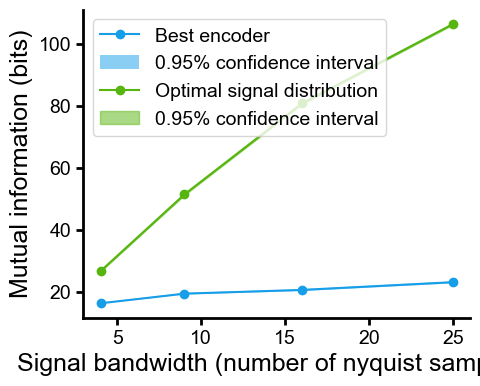

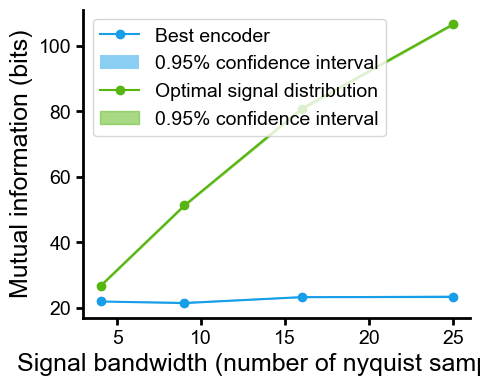

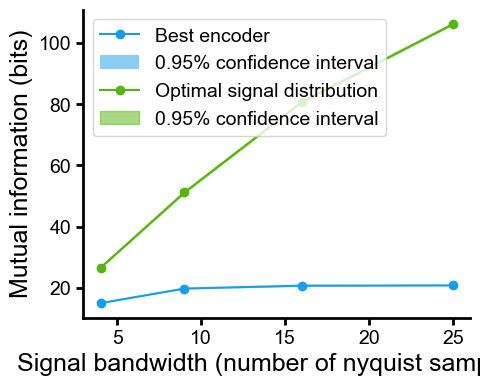

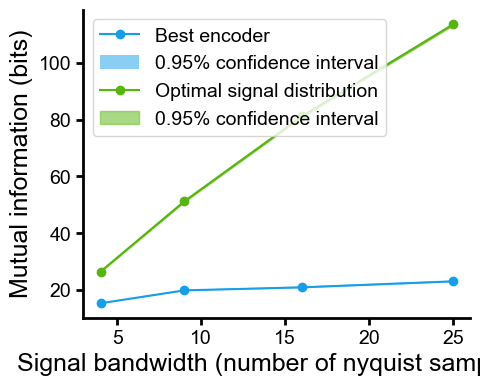

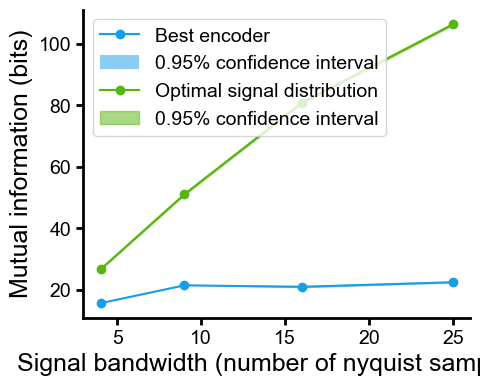

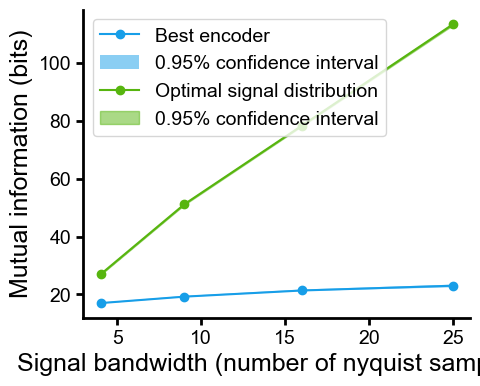

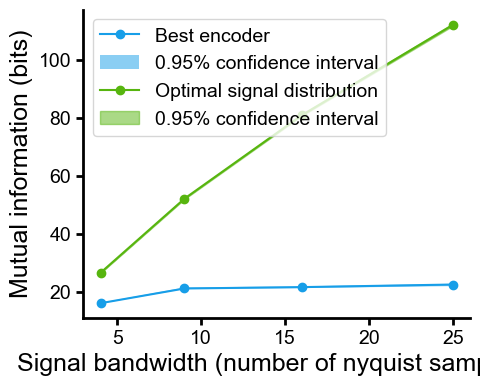

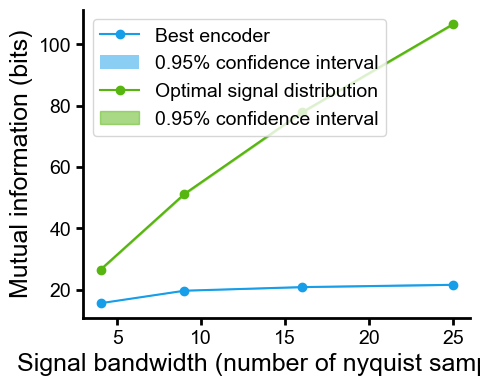

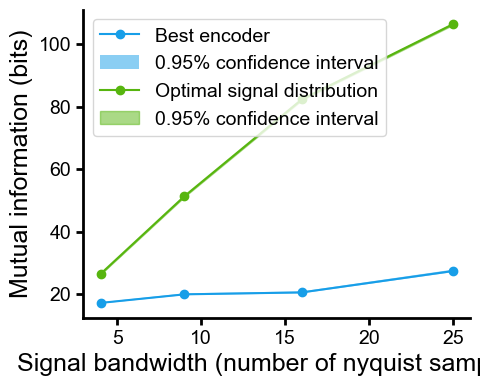

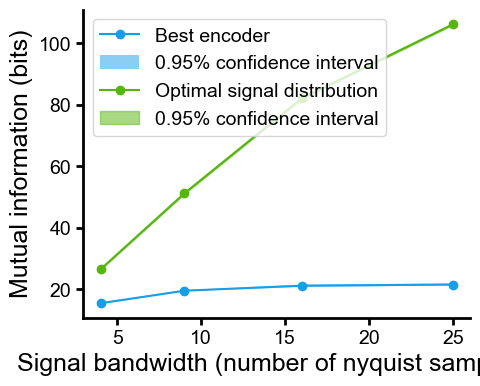

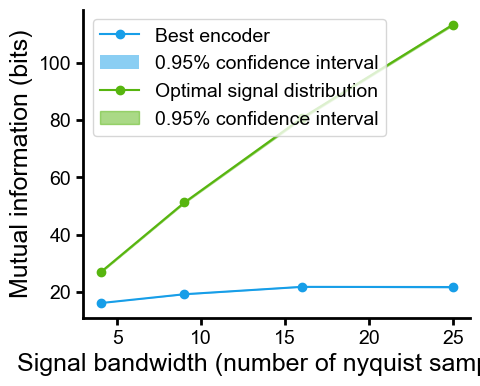

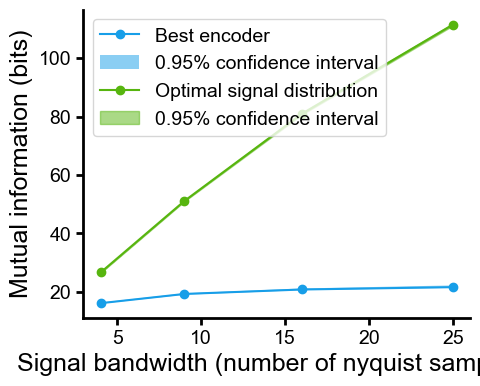

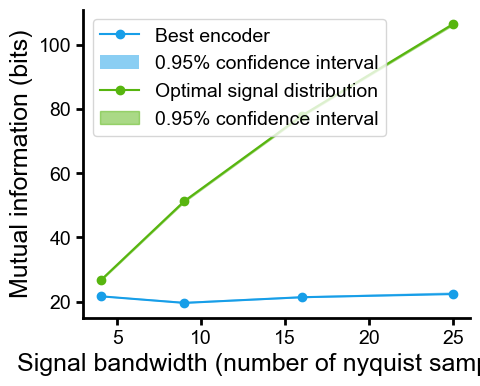

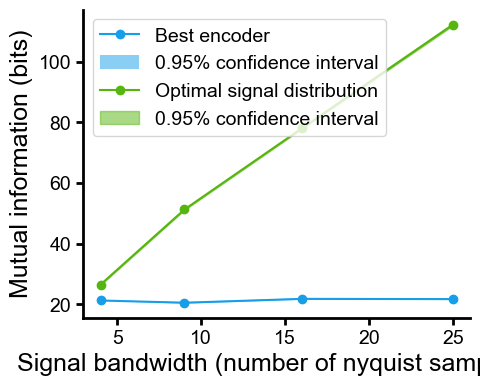

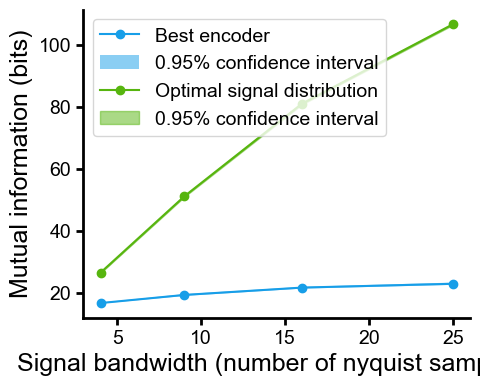

In [5]:
num_nyquist_samples_list = [4, 9, 16, 25]
key = jax.random.PRNGKey(0)
noise_sigma = 1e-3
num_objects = 8000
num_replicates = 15



conv_mi_list = []
uniform_mi_list = []
for i in tqdm(range(num_replicates), desc="Replicates"):
    mi_list = []
    mi_uniform_list = []
    for num_nyquist_samples in tqdm(num_nyquist_samples_list, desc="Nyquist Samples", leave=False):
        upsampled_signal_length = num_nyquist_samples * 32

        # Compute MI for optimized encoder
        conv_info, conv_lower_bound, conv_upper_bound, subkey = compute_mutual_information_for_optimized_encoder(
            num_objects, num_nyquist_samples, noise_sigma, key, upsampled_signal_length=upsampled_signal_length)
        # multiply by number of nyquist samples to get the same scale as the other
        conv_info *= num_nyquist_samples
        conv_lower_bound *= num_nyquist_samples
        conv_upper_bound *= num_nyquist_samples
        mi_list.append((conv_info, conv_lower_bound, conv_upper_bound))
        _, key = jax.random.split(key)

        # Compute MI for uniform samples (if needed per replicate)
        uniform_info, uniform_lower_bound, uniform_upper_bound = compute_uniform_samples_mi(
            num_objects, num_nyquist_samples, noise_sigma, key, upsampled_signal_length=upsampled_signal_length)
        # multiply by number of nyquist samples to get the same scale as the other
        uniform_info *= num_nyquist_samples
        uniform_lower_bound *= num_nyquist_samples
        uniform_upper_bound *= num_nyquist_samples
        mi_uniform_list.append((uniform_info, uniform_lower_bound, uniform_upper_bound))
        _, key = jax.random.split(key)

    
    conv_mi, conv_mi_lower, conv_mi_upper = zip(*mi_list)
    uniform_mi, uniform_mi_lower, uniform_mi_upper = zip(*mi_uniform_list)

    conv_mi_list.append((conv_mi, conv_mi_lower, conv_mi_upper))
    uniform_mi_list.append((uniform_mi, uniform_mi_lower, uniform_mi_upper))

    make_uniform_conv_mi_plot(conv_mi, conv_mi_lower, conv_mi_upper, 
                                uniform_mi, uniform_mi_lower, uniform_mi_upper, num_nyquist_samples_list)
    plt.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'actual_vs_optimal_mi_replicate{i}' + '.pdf', transparent=True)


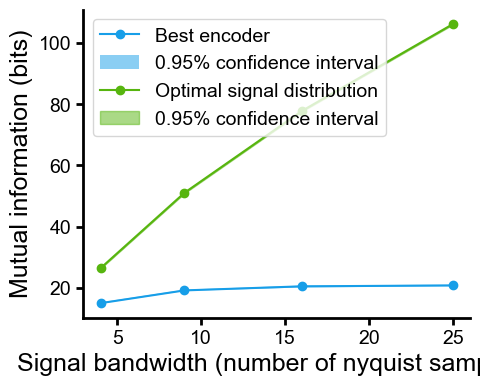

In [6]:
# num replicates x (estimate, lower, upper) x num nyquist samples
conv_mi_list = np.array(conv_mi_list)
best_conv_index = np.argmin(conv_mi_list[:, 0, :], axis=0)
best_conv = conv_mi_list[best_conv_index, np.arange(conv_mi_list.shape[1])[:, None], np.arange(conv_mi_list.shape[2])]
mi_conv, mi_conv_lower, mi_conv_upper = best_conv


uniform_mi_list = np.array(uniform_mi_list)
best_uniform_index = np.argmin(uniform_mi_list[:, 0, :], axis=0)
best_uniform = uniform_mi_list[best_uniform_index, np.arange(uniform_mi_list.shape[1])[:, None], np.arange(uniform_mi_list.shape[2])]
mi_uniform, mi_uniform_lower, mi_uniform_upper = best_uniform


# make_uniform_conv_mi_plot(conv_mi, conv_mi_lower, conv_mi_upper,
#                             uniform_mi, uniform_mi_lower, uniform_mi_upper, num_nyquist_samples_list)
make_uniform_conv_mi_plot(mi_conv, mi_conv_lower, mi_conv_upper,
                            mi_uniform, mi_uniform_lower, mi_uniform_upper, num_nyquist_samples_list)
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + 'actual_vs_optimal_mi' + '.pdf', transparent=True)

## Make plots of optimal and actual distributions

In [7]:
# generate the signals

def compute_best_encoded_signals(num_objects, num_nyquist_samples, noise_sigma, key,
                                                     upsampled_signal_length=UPSAMPLED_SIGNAL_LENGTH):
    
    objects_fn = lambda : np.array([generate_random_object('delta', object_size=upsampled_signal_length)
                                     for i in range(num_objects)])

    initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=True, upsampled_signal_length=upsampled_signal_length)
    initial_params = params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples)
    loss_fn = make_convolutional_forward_model_with_mi_loss(objects_fn(), noise_sigma, num_nyquist_samples=num_nyquist_samples, 
                                                            upsampled_signal_length=upsampled_signal_length)
    optimized_params = run_optimzation(loss_fn, lambda x : signal_prox_fn(x, num_nyquist_samples=num_nyquist_samples), 
                            initial_params,
                              learning_rate=1e-2, learning_rate_decay=0.999,
                              verbose=True,
                            loss_improvement_patience=1000, max_epochs=1000, key=key)

    output_signals = conv_forward_model(optimized_params, objects_fn(), num_nyquist_samples=num_nyquist_samples, integrate_output_signals=False, 
                                        upsampled_signal_length=upsampled_signal_length)
    return key, output_signals

key = jax.random.PRNGKey(0)
noise_sigma = 1e-3
num_objects = 50000

num_nyquist_samples = 4
upsampled_signal_length = num_nyquist_samples * 256

key, signals_encoded = compute_best_encoded_signals(num_objects, num_nyquist_samples, noise_sigma, key,          
                                                        upsampled_signal_length=upsampled_signal_length)
signals_uniform = generate_uniform_random_bandlimited_signals(num_nyquist_samples=num_nyquist_samples, num_signals=num_objects,upsampled_signal_length=upsampled_signal_length)

initial loss -5.652240467076812


Generating signals: 50001it [01:14, 669.41it/s]


concatenating...


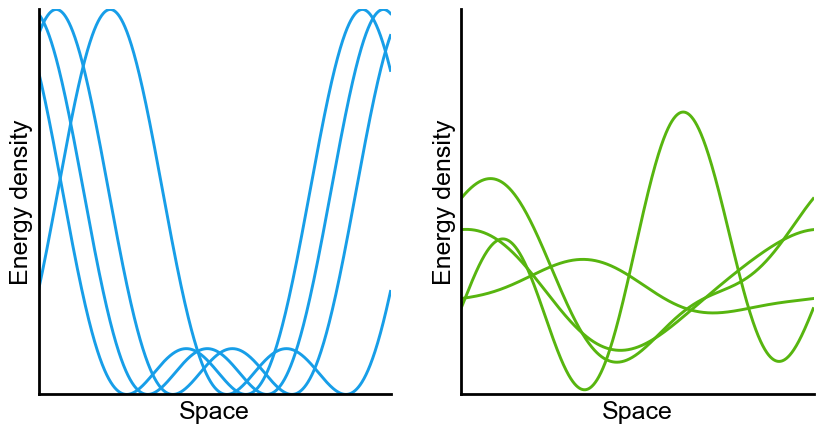

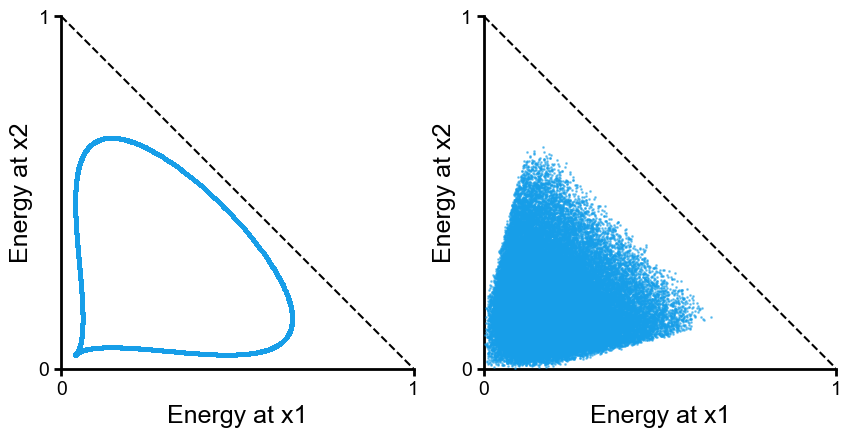

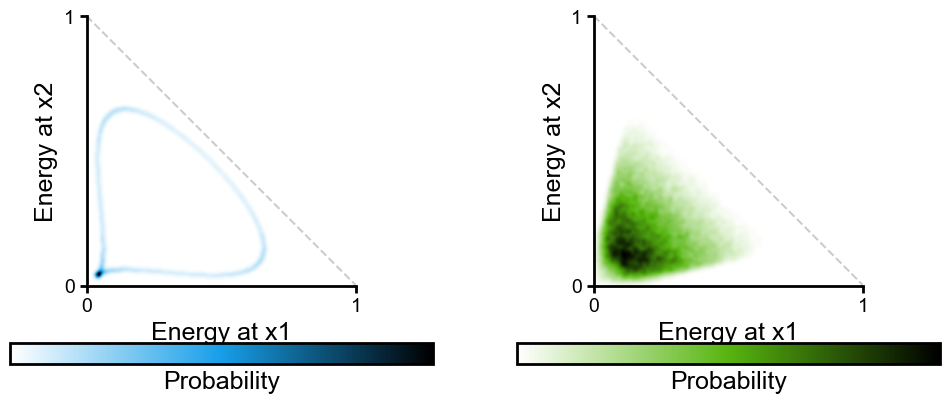

In [8]:
# Make plots
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors



fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ymax = max(onp.max(signals_encoded), onp.max(signals_uniform))
plot_in_spatial_coordinates(ax[0], signals_encoded[:4], num_nyquist_samples=num_nyquist_samples, ymax=ymax, color=get_color_cycle()[0])
plot_in_spatial_coordinates(ax[1], signals_uniform[:4], num_nyquist_samples=num_nyquist_samples, ymax=ymax, color=get_color_cycle()[3])
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'actual_vs_optimal_example_signals_{num_nyquist_samples}_nyquist' + '.pdf', transparent=True)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_intensity_coordinates(ax[0], signals_encoded, num_nyquist_samples=num_nyquist_samples, s=3, alpha=0.5,)
plot_in_intensity_coordinates(ax[1], signals_uniform, num_nyquist_samples=num_nyquist_samples, s=1, alpha=0.5,)


def plot_distribution(ax, x, y, cmap):

    # bin into 2d histogram
    num_bins = 250
    sigma_smooth = 2
    xx, yy = np.meshgrid(np.linspace(0, 1, num_bins), np.linspace(0, 1, num_bins))
    hist, xedges, yedges = np.histogram2d(x, y, bins=[xx[0], yy[:, 0]])
    hist = hist.astype(np.float32)
    hist = gaussian_filter(hist, sigma=sigma_smooth)
    hist /= hist.sum()
    im = ax.imshow(hist.T, origin='lower', extent=[0, 1, 0, 1], cmap=cmap)
    # plot the dotted line from [1, 0] to [0, 1]
    ax.plot([0, 1], [1, 0], '--', color='k', alpha=0.2)
    # add a colorbar to this axis
    colorbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15)
    colorbar.set_label('Probability')
    colorbar.set_ticks([])  # Hides the ticks
    clear_spines(ax)
    ax.set(yticks=[0, 1], xticks=[0, 1], xlabel='Energy at x1', ylabel='Energy at x2')



fig, ax = plt.subplots(1, 2, figsize=(12, 5))
encoded_integrated = integrate_pixels(signals_encoded, num_nyquist_samples=num_nyquist_samples)
uniform_integrated = integrate_pixels(signals_uniform, num_nyquist_samples=num_nyquist_samples)

cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["white", get_color_cycle()[0], 'black'])
plot_distribution(ax[0], encoded_integrated[:, 0], encoded_integrated[:, 1], cmap)
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["white", get_color_cycle()[3], 'black'])
plot_distribution(ax[1], uniform_integrated[:, 0], uniform_integrated[:, 1], cmap)

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'actual_vs_optimal_distribution_{num_nyquist_samples}_nyquist' + '.pdf', transparent=True)